In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4120016, 828)
(4120016, 8)
validation
(639632, 828)
(639632, 8)
test
(362880, 828)
(362880, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/413 [..............................] - ETA: 8:39 - loss: 2.3759 - STD: 0.0930 - MAE: 0.2199

  5/413 [..............................] - ETA: 6s - loss: 2.1539 - STD: 0.0491 - MAE: 0.2181  

  9/413 [..............................] - ETA: 6s - loss: 2.1293 - STD: 0.0581 - MAE: 0.2166

 13/413 [..............................] - ETA: 6s - loss: 2.1081 - STD: 0.0513 - MAE: 0.2166

 17/413 [>.............................] - ETA: 6s - loss: 2.0961 - STD: 0.0447 - MAE: 0.2168

 21/413 [>.............................] - ETA: 6s - loss: 2.0883 - STD: 0.0416 - MAE: 0.2168

 25/413 [>.............................] - ETA: 6s - loss: 2.0814 - STD: 0.0400 - MAE: 0.2168

 29/413 [=>............................] - ETA: 6s - loss: 2.0755 - STD: 0.0394 - MAE: 0.2167

 33/413 [=>............................] - ETA: 5s - loss: 2.0688 - STD: 0.0392 - MAE: 0.2165

 37/413 [=>............................] - ETA: 5s - loss: 2.0599 - STD: 0.0388 - MAE: 0.2163

 41/413 [=>............................] - ETA: 5s - loss: 2.0498 - STD: 0.0393 - MAE: 0.2159

 45/413 [==>...........................] - ETA: 5s - loss: 2.0380 - STD: 0.0407 - MAE: 0.2155

 49/413 [==>...........................] - ETA: 5s - loss: 2.0264 - STD: 0.0430 - MAE: 0.2149

 53/413 [==>...........................] - ETA: 5s - loss: 2.0146 - STD: 0.0456 - MAE: 0.2142

 57/413 [===>..........................] - ETA: 5s - loss: 2.0028 - STD: 0.0478 - MAE: 0.2136

 61/413 [===>..........................] - ETA: 5s - loss: 1.9908 - STD: 0.0496 - MAE: 0.2131

 65/413 [===>..........................] - ETA: 5s - loss: 1.9789 - STD: 0.0517 - MAE: 0.2125

 69/413 [====>.........................] - ETA: 5s - loss: 1.9671 - STD: 0.0537 - MAE: 0.2119

 73/413 [====>.........................] - ETA: 5s - loss: 1.9558 - STD: 0.0555 - MAE: 0.2114

 77/413 [====>.........................] - ETA: 5s - loss: 1.9450 - STD: 0.0574 - MAE: 0.2108

 81/413 [====>.........................] - ETA: 5s - loss: 1.9347 - STD: 0.0591 - MAE: 0.2103

 85/413 [=====>........................] - ETA: 5s - loss: 1.9249 - STD: 0.0607 - MAE: 0.2098

 89/413 [=====>........................] - ETA: 5s - loss: 1.9153 - STD: 0.0622 - MAE: 0.2093

 93/413 [=====>........................] - ETA: 4s - loss: 1.9057 - STD: 0.0638 - MAE: 0.2088

 97/413 [======>.......................] - ETA: 4s - loss: 1.8963 - STD: 0.0653 - MAE: 0.2083

101/413 [======>.......................] - ETA: 4s - loss: 1.8864 - STD: 0.0667 - MAE: 0.2077

105/413 [======>.......................] - ETA: 4s - loss: 1.8763 - STD: 0.0683 - MAE: 0.2071

109/413 [======>.......................] - ETA: 4s - loss: 1.8663 - STD: 0.0698 - MAE: 0.2065

113/413 [=======>......................] - ETA: 4s - loss: 1.8562 - STD: 0.0715 - MAE: 0.2059

117/413 [=======>......................] - ETA: 4s - loss: 1.8463 - STD: 0.0731 - MAE: 0.2053

121/413 [=======>......................] - ETA: 4s - loss: 1.8363 - STD: 0.0747 - MAE: 0.2046

125/413 [========>.....................] - ETA: 4s - loss: 1.8265 - STD: 0.0763 - MAE: 0.2039

129/413 [========>.....................] - ETA: 4s - loss: 1.8168 - STD: 0.0780 - MAE: 0.2033

133/413 [========>.....................] - ETA: 4s - loss: 1.8074 - STD: 0.0795 - MAE: 0.2026

137/413 [========>.....................] - ETA: 4s - loss: 1.7981 - STD: 0.0811 - MAE: 0.2020

141/413 [=========>....................] - ETA: 4s - loss: 1.7891 - STD: 0.0825 - MAE: 0.2014

145/413 [=========>....................] - ETA: 4s - loss: 1.7801 - STD: 0.0840 - MAE: 0.2008

149/413 [=========>....................] - ETA: 4s - loss: 1.7714 - STD: 0.0854 - MAE: 0.2001

153/413 [==========>...................] - ETA: 3s - loss: 1.7629 - STD: 0.0868 - MAE: 0.1995

157/413 [==========>...................] - ETA: 3s - loss: 1.7544 - STD: 0.0883 - MAE: 0.1989

161/413 [==========>...................] - ETA: 3s - loss: 1.7461 - STD: 0.0896 - MAE: 0.1983

165/413 [==========>...................] - ETA: 3s - loss: 1.7381 - STD: 0.0910 - MAE: 0.1977

169/413 [===========>..................] - ETA: 3s - loss: 1.7304 - STD: 0.0924 - MAE: 0.1971

173/413 [===========>..................] - ETA: 3s - loss: 1.7230 - STD: 0.0937 - MAE: 0.1965

177/413 [===========>..................] - ETA: 3s - loss: 1.7157 - STD: 0.0950 - MAE: 0.1960

181/413 [============>.................] - ETA: 3s - loss: 1.7085 - STD: 0.0963 - MAE: 0.1954

182/413 [============>.................] - ETA: 5s - loss: 1.7085 - STD: 0.0966 - MAE: 0.1952

186/413 [============>.................] - ETA: 5s - loss: 1.7025 - STD: 0.0979 - MAE: 0.1947

190/413 [============>.................] - ETA: 5s - loss: 1.6962 - STD: 0.0991 - MAE: 0.1942

194/413 [=============>................] - ETA: 5s - loss: 1.6902 - STD: 0.1003 - MAE: 0.1937

198/413 [=============>................] - ETA: 4s - loss: 1.6838 - STD: 0.1014 - MAE: 0.1932

202/413 [=============>................] - ETA: 4s - loss: 1.6778 - STD: 0.1024 - MAE: 0.1927

206/413 [=============>................] - ETA: 4s - loss: 1.6721 - STD: 0.1034 - MAE: 0.1923

210/413 [==============>...............] - ETA: 4s - loss: 1.6663 - STD: 0.1044 - MAE: 0.1918

214/413 [==============>...............] - ETA: 4s - loss: 1.6606 - STD: 0.1054 - MAE: 0.1914

218/413 [==============>...............] - ETA: 4s - loss: 1.6552 - STD: 0.1064 - MAE: 0.1910

222/413 [===============>..............] - ETA: 4s - loss: 1.6500 - STD: 0.1073 - MAE: 0.1905

226/413 [===============>..............] - ETA: 4s - loss: 1.6448 - STD: 0.1082 - MAE: 0.1901

230/413 [===============>..............] - ETA: 4s - loss: 1.6399 - STD: 0.1090 - MAE: 0.1898

234/413 [===============>..............] - ETA: 3s - loss: 1.6351 - STD: 0.1099 - MAE: 0.1894

238/413 [================>.............] - ETA: 3s - loss: 1.6304 - STD: 0.1107 - MAE: 0.1890

242/413 [================>.............] - ETA: 3s - loss: 1.6258 - STD: 0.1115 - MAE: 0.1886

246/413 [================>.............] - ETA: 3s - loss: 1.6212 - STD: 0.1123 - MAE: 0.1883

250/413 [=================>............] - ETA: 3s - loss: 1.6168 - STD: 0.1130 - MAE: 0.1879

254/413 [=================>............] - ETA: 3s - loss: 1.6124 - STD: 0.1138 - MAE: 0.1876

258/413 [=================>............] - ETA: 3s - loss: 1.6081 - STD: 0.1145 - MAE: 0.1872

262/413 [==================>...........] - ETA: 3s - loss: 1.6041 - STD: 0.1152 - MAE: 0.1869

266/413 [==================>...........] - ETA: 3s - loss: 1.5999 - STD: 0.1159 - MAE: 0.1866

270/413 [==================>...........] - ETA: 3s - loss: 1.5959 - STD: 0.1166 - MAE: 0.1863

274/413 [==================>...........] - ETA: 2s - loss: 1.5922 - STD: 0.1172 - MAE: 0.1859

278/413 [===================>..........] - ETA: 2s - loss: 1.5884 - STD: 0.1179 - MAE: 0.1856

282/413 [===================>..........] - ETA: 2s - loss: 1.5847 - STD: 0.1185 - MAE: 0.1853

286/413 [===================>..........] - ETA: 2s - loss: 1.5811 - STD: 0.1192 - MAE: 0.1850

290/413 [====================>.........] - ETA: 2s - loss: 1.5776 - STD: 0.1198 - MAE: 0.1847

294/413 [====================>.........] - ETA: 2s - loss: 1.5741 - STD: 0.1204 - MAE: 0.1845

298/413 [====================>.........] - ETA: 2s - loss: 1.5708 - STD: 0.1210 - MAE: 0.1842

302/413 [====================>.........] - ETA: 2s - loss: 1.5674 - STD: 0.1215 - MAE: 0.1839

306/413 [=====================>........] - ETA: 2s - loss: 1.5640 - STD: 0.1221 - MAE: 0.1836

310/413 [=====================>........] - ETA: 2s - loss: 1.5606 - STD: 0.1227 - MAE: 0.1834

314/413 [=====================>........] - ETA: 2s - loss: 1.5573 - STD: 0.1232 - MAE: 0.1831

318/413 [======================>.......] - ETA: 1s - loss: 1.5540 - STD: 0.1238 - MAE: 0.1828

322/413 [======================>.......] - ETA: 1s - loss: 1.5508 - STD: 0.1243 - MAE: 0.1826

326/413 [======================>.......] - ETA: 1s - loss: 1.5477 - STD: 0.1248 - MAE: 0.1823

330/413 [======================>.......] - ETA: 1s - loss: 1.5446 - STD: 0.1253 - MAE: 0.1820

334/413 [=======================>......] - ETA: 1s - loss: 1.5415 - STD: 0.1258 - MAE: 0.1818

338/413 [=======================>......] - ETA: 1s - loss: 1.5384 - STD: 0.1263 - MAE: 0.1815

342/413 [=======================>......] - ETA: 1s - loss: 1.5354 - STD: 0.1268 - MAE: 0.1813

346/413 [========================>.....] - ETA: 1s - loss: 1.5325 - STD: 0.1273 - MAE: 0.1811

350/413 [========================>.....] - ETA: 1s - loss: 1.5296 - STD: 0.1278 - MAE: 0.1808

354/413 [========================>.....] - ETA: 1s - loss: 1.5267 - STD: 0.1283 - MAE: 0.1806

358/413 [=========================>....] - ETA: 1s - loss: 1.5240 - STD: 0.1287 - MAE: 0.1803

362/413 [=========================>....] - ETA: 1s - loss: 1.5214 - STD: 0.1292 - MAE: 0.1801

366/413 [=========================>....] - ETA: 0s - loss: 1.5188 - STD: 0.1296 - MAE: 0.1799

370/413 [=========================>....] - ETA: 0s - loss: 1.5161 - STD: 0.1301 - MAE: 0.1797

374/413 [==========================>...] - ETA: 0s - loss: 1.5134 - STD: 0.1305 - MAE: 0.1794

378/413 [==========================>...] - ETA: 0s - loss: 1.5108 - STD: 0.1309 - MAE: 0.1792

382/413 [==========================>...] - ETA: 0s - loss: 1.5081 - STD: 0.1314 - MAE: 0.1790

386/413 [===========================>..] - ETA: 0s - loss: 1.5056 - STD: 0.1318 - MAE: 0.1788

390/413 [===========================>..] - ETA: 0s - loss: 1.5031 - STD: 0.1322 - MAE: 0.1786

394/413 [===========================>..] - ETA: 0s - loss: 1.5005 - STD: 0.1326 - MAE: 0.1784

398/413 [===========================>..] - ETA: 0s - loss: 1.4980 - STD: 0.1330 - MAE: 0.1781

402/413 [============================>.] - ETA: 0s - loss: 1.4955 - STD: 0.1334 - MAE: 0.1779

406/413 [============================>.] - ETA: 0s - loss: 1.4931 - STD: 0.1338 - MAE: 0.1777

410/413 [============================>.] - ETA: 0s - loss: 1.4907 - STD: 0.1342 - MAE: 0.1775

413/413 [==============================] - 10s 22ms/step - loss: 1.4893 - STD: 0.1345 - MAE: 0.1774 - val_loss: 1.4852 - val_STD: 0.1638 - val_MAE: 0.1700


Epoch 2/10000


  1/413 [..............................] - ETA: 17s - loss: 1.2693 - STD: 0.1729 - MAE: 0.1584

  4/413 [..............................] - ETA: 7s - loss: 1.2675 - STD: 0.1737 - MAE: 0.1578 

  8/413 [..............................] - ETA: 6s - loss: 1.2655 - STD: 0.1738 - MAE: 0.1576

 12/413 [..............................] - ETA: 6s - loss: 1.2659 - STD: 0.1739 - MAE: 0.1576

 15/413 [>.............................] - ETA: 6s - loss: 1.2614 - STD: 0.1740 - MAE: 0.1574

 19/413 [>.............................] - ETA: 6s - loss: 1.2597 - STD: 0.1740 - MAE: 0.1573

 23/413 [>.............................] - ETA: 6s - loss: 1.2542 - STD: 0.1741 - MAE: 0.1570

 27/413 [>.............................] - ETA: 6s - loss: 1.2514 - STD: 0.1742 - MAE: 0.1568

 31/413 [=>............................] - ETA: 6s - loss: 1.2477 - STD: 0.1743 - MAE: 0.1566

 35/413 [=>............................] - ETA: 5s - loss: 1.2448 - STD: 0.1745 - MAE: 0.1563

 39/413 [=>............................] - ETA: 5s - loss: 1.2429 - STD: 0.1747 - MAE: 0.1562

 43/413 [==>...........................] - ETA: 5s - loss: 1.2405 - STD: 0.1750 - MAE: 0.1560

 47/413 [==>...........................] - ETA: 5s - loss: 1.2392 - STD: 0.1751 - MAE: 0.1559

 51/413 [==>...........................] - ETA: 5s - loss: 1.2377 - STD: 0.1753 - MAE: 0.1558

 55/413 [==>...........................] - ETA: 5s - loss: 1.2360 - STD: 0.1754 - MAE: 0.1556

 59/413 [===>..........................] - ETA: 5s - loss: 1.2348 - STD: 0.1755 - MAE: 0.1555

 63/413 [===>..........................] - ETA: 5s - loss: 1.2329 - STD: 0.1757 - MAE: 0.1554

 67/413 [===>..........................] - ETA: 5s - loss: 1.2318 - STD: 0.1759 - MAE: 0.1553

 70/413 [====>.........................] - ETA: 5s - loss: 1.2312 - STD: 0.1760 - MAE: 0.1552

 74/413 [====>.........................] - ETA: 5s - loss: 1.2300 - STD: 0.1761 - MAE: 0.1551

 79/413 [====>.........................] - ETA: 5s - loss: 1.2426 - STD: 0.1767 - MAE: 0.1555

 83/413 [=====>........................] - ETA: 5s - loss: 1.2467 - STD: 0.1767 - MAE: 0.1557

 87/413 [=====>........................] - ETA: 5s - loss: 1.2495 - STD: 0.1767 - MAE: 0.1559

 91/413 [=====>........................] - ETA: 4s - loss: 1.2498 - STD: 0.1768 - MAE: 0.1559

 95/413 [=====>........................] - ETA: 4s - loss: 1.2495 - STD: 0.1768 - MAE: 0.1559

 99/413 [======>.......................] - ETA: 4s - loss: 1.2485 - STD: 0.1768 - MAE: 0.1558

103/413 [======>.......................] - ETA: 4s - loss: 1.2473 - STD: 0.1769 - MAE: 0.1557

107/413 [======>.......................] - ETA: 4s - loss: 1.2461 - STD: 0.1768 - MAE: 0.1557

111/413 [=======>......................] - ETA: 4s - loss: 1.2446 - STD: 0.1769 - MAE: 0.1556

115/413 [=======>......................] - ETA: 4s - loss: 1.2430 - STD: 0.1769 - MAE: 0.1555

118/413 [=======>......................] - ETA: 4s - loss: 1.2420 - STD: 0.1770 - MAE: 0.1554

122/413 [=======>......................] - ETA: 4s - loss: 1.2404 - STD: 0.1771 - MAE: 0.1553

126/413 [========>.....................] - ETA: 4s - loss: 1.2388 - STD: 0.1772 - MAE: 0.1552

130/413 [========>.....................] - ETA: 4s - loss: 1.2372 - STD: 0.1772 - MAE: 0.1551

134/413 [========>.....................] - ETA: 4s - loss: 1.2360 - STD: 0.1773 - MAE: 0.1550

138/413 [=========>....................] - ETA: 4s - loss: 1.2348 - STD: 0.1774 - MAE: 0.1549

142/413 [=========>....................] - ETA: 4s - loss: 1.2340 - STD: 0.1776 - MAE: 0.1548

146/413 [=========>....................] - ETA: 4s - loss: 1.2329 - STD: 0.1777 - MAE: 0.1547

150/413 [=========>....................] - ETA: 4s - loss: 1.2318 - STD: 0.1778 - MAE: 0.1546

154/413 [==========>...................] - ETA: 3s - loss: 1.2306 - STD: 0.1778 - MAE: 0.1546

158/413 [==========>...................] - ETA: 3s - loss: 1.2295 - STD: 0.1779 - MAE: 0.1545

162/413 [==========>...................] - ETA: 3s - loss: 1.2282 - STD: 0.1781 - MAE: 0.1544

166/413 [===========>..................] - ETA: 3s - loss: 1.2270 - STD: 0.1782 - MAE: 0.1543

170/413 [===========>..................] - ETA: 3s - loss: 1.2268 - STD: 0.1783 - MAE: 0.1542

174/413 [===========>..................] - ETA: 3s - loss: 1.2261 - STD: 0.1784 - MAE: 0.1541

178/413 [===========>..................] - ETA: 3s - loss: 1.2253 - STD: 0.1785 - MAE: 0.1540

182/413 [============>.................] - ETA: 3s - loss: 1.2245 - STD: 0.1786 - MAE: 0.1540

186/413 [============>.................] - ETA: 3s - loss: 1.2238 - STD: 0.1787 - MAE: 0.1539

190/413 [============>.................] - ETA: 3s - loss: 1.2231 - STD: 0.1788 - MAE: 0.1538

194/413 [=============>................] - ETA: 3s - loss: 1.2222 - STD: 0.1789 - MAE: 0.1538

198/413 [=============>................] - ETA: 3s - loss: 1.2211 - STD: 0.1790 - MAE: 0.1537

202/413 [=============>................] - ETA: 3s - loss: 1.2201 - STD: 0.1790 - MAE: 0.1536

206/413 [=============>................] - ETA: 3s - loss: 1.2191 - STD: 0.1791 - MAE: 0.1535

210/413 [==============>...............] - ETA: 3s - loss: 1.2181 - STD: 0.1792 - MAE: 0.1534

214/413 [==============>...............] - ETA: 3s - loss: 1.2171 - STD: 0.1793 - MAE: 0.1533

218/413 [==============>...............] - ETA: 3s - loss: 1.2162 - STD: 0.1794 - MAE: 0.1532

222/413 [===============>..............] - ETA: 2s - loss: 1.2153 - STD: 0.1795 - MAE: 0.1532

226/413 [===============>..............] - ETA: 2s - loss: 1.2146 - STD: 0.1796 - MAE: 0.1531

230/413 [===============>..............] - ETA: 2s - loss: 1.2138 - STD: 0.1797 - MAE: 0.1530

234/413 [===============>..............] - ETA: 2s - loss: 1.2131 - STD: 0.1798 - MAE: 0.1529

238/413 [================>.............] - ETA: 2s - loss: 1.2124 - STD: 0.1799 - MAE: 0.1529

242/413 [================>.............] - ETA: 2s - loss: 1.2116 - STD: 0.1800 - MAE: 0.1528

246/413 [================>.............] - ETA: 2s - loss: 1.2107 - STD: 0.1801 - MAE: 0.1527

250/413 [=================>............] - ETA: 2s - loss: 1.2099 - STD: 0.1802 - MAE: 0.1527

254/413 [=================>............] - ETA: 2s - loss: 1.2091 - STD: 0.1803 - MAE: 0.1526

258/413 [=================>............] - ETA: 2s - loss: 1.2084 - STD: 0.1804 - MAE: 0.1525

262/413 [==================>...........] - ETA: 2s - loss: 1.2077 - STD: 0.1805 - MAE: 0.1524

266/413 [==================>...........] - ETA: 2s - loss: 1.2070 - STD: 0.1806 - MAE: 0.1524

270/413 [==================>...........] - ETA: 2s - loss: 1.2065 - STD: 0.1807 - MAE: 0.1523

274/413 [==================>...........] - ETA: 2s - loss: 1.2059 - STD: 0.1807 - MAE: 0.1522

278/413 [===================>..........] - ETA: 2s - loss: 1.2052 - STD: 0.1808 - MAE: 0.1522

282/413 [===================>..........] - ETA: 2s - loss: 1.2046 - STD: 0.1809 - MAE: 0.1521

286/413 [===================>..........] - ETA: 1s - loss: 1.2039 - STD: 0.1810 - MAE: 0.1521

290/413 [====================>.........] - ETA: 1s - loss: 1.2031 - STD: 0.1811 - MAE: 0.1520

294/413 [====================>.........] - ETA: 1s - loss: 1.2026 - STD: 0.1812 - MAE: 0.1519

298/413 [====================>.........] - ETA: 1s - loss: 1.2019 - STD: 0.1812 - MAE: 0.1519

302/413 [====================>.........] - ETA: 1s - loss: 1.2013 - STD: 0.1813 - MAE: 0.1518

306/413 [=====================>........] - ETA: 1s - loss: 1.2008 - STD: 0.1814 - MAE: 0.1518

310/413 [=====================>........] - ETA: 1s - loss: 1.2003 - STD: 0.1815 - MAE: 0.1517

314/413 [=====================>........] - ETA: 1s - loss: 1.1997 - STD: 0.1816 - MAE: 0.1516

318/413 [======================>.......] - ETA: 1s - loss: 1.1994 - STD: 0.1817 - MAE: 0.1516

322/413 [======================>.......] - ETA: 1s - loss: 1.1989 - STD: 0.1817 - MAE: 0.1515

326/413 [======================>.......] - ETA: 1s - loss: 1.1984 - STD: 0.1818 - MAE: 0.1515

330/413 [======================>.......] - ETA: 1s - loss: 1.1978 - STD: 0.1819 - MAE: 0.1514

334/413 [=======================>......] - ETA: 1s - loss: 1.1971 - STD: 0.1820 - MAE: 0.1514

338/413 [=======================>......] - ETA: 1s - loss: 1.1965 - STD: 0.1821 - MAE: 0.1513

342/413 [=======================>......] - ETA: 1s - loss: 1.1957 - STD: 0.1821 - MAE: 0.1512

346/413 [========================>.....] - ETA: 1s - loss: 1.1952 - STD: 0.1822 - MAE: 0.1512

350/413 [========================>.....] - ETA: 0s - loss: 1.1946 - STD: 0.1823 - MAE: 0.1511

354/413 [========================>.....] - ETA: 0s - loss: 1.1940 - STD: 0.1824 - MAE: 0.1511

358/413 [=========================>....] - ETA: 0s - loss: 1.1933 - STD: 0.1824 - MAE: 0.1510

362/413 [=========================>....] - ETA: 0s - loss: 1.1927 - STD: 0.1825 - MAE: 0.1509

366/413 [=========================>....] - ETA: 0s - loss: 1.1922 - STD: 0.1826 - MAE: 0.1509

370/413 [=========================>....] - ETA: 0s - loss: 1.1917 - STD: 0.1827 - MAE: 0.1508

374/413 [==========================>...] - ETA: 0s - loss: 1.1913 - STD: 0.1828 - MAE: 0.1508

378/413 [==========================>...] - ETA: 0s - loss: 1.1909 - STD: 0.1828 - MAE: 0.1507

382/413 [==========================>...] - ETA: 0s - loss: 1.1904 - STD: 0.1829 - MAE: 0.1507

386/413 [===========================>..] - ETA: 0s - loss: 1.1898 - STD: 0.1830 - MAE: 0.1506

390/413 [===========================>..] - ETA: 0s - loss: 1.1892 - STD: 0.1830 - MAE: 0.1506

394/413 [===========================>..] - ETA: 0s - loss: 1.1886 - STD: 0.1831 - MAE: 0.1505

398/413 [===========================>..] - ETA: 0s - loss: 1.1880 - STD: 0.1832 - MAE: 0.1504

402/413 [============================>.] - ETA: 0s - loss: 1.1874 - STD: 0.1833 - MAE: 0.1504

406/413 [============================>.] - ETA: 0s - loss: 1.1868 - STD: 0.1833 - MAE: 0.1503

410/413 [============================>.] - ETA: 0s - loss: 1.1862 - STD: 0.1834 - MAE: 0.1503

413/413 [==============================] - 7s 17ms/step - loss: 1.1857 - STD: 0.1835 - MAE: 0.1502 - val_loss: 1.4483 - val_STD: 0.1851 - val_MAE: 0.1616


Epoch 3/10000


  1/413 [..............................] - ETA: 21s - loss: 1.1227 - STD: 0.1889 - MAE: 0.1447

  4/413 [..............................] - ETA: 6s - loss: 1.1207 - STD: 0.1906 - MAE: 0.1441 

  8/413 [..............................] - ETA: 6s - loss: 1.1242 - STD: 0.1912 - MAE: 0.1441

 12/413 [..............................] - ETA: 6s - loss: 1.1269 - STD: 0.1913 - MAE: 0.1442

 16/413 [>.............................] - ETA: 6s - loss: 1.1243 - STD: 0.1912 - MAE: 0.1441

 20/413 [>.............................] - ETA: 6s - loss: 1.1237 - STD: 0.1913 - MAE: 0.1440

 24/413 [>.............................] - ETA: 6s - loss: 1.1223 - STD: 0.1916 - MAE: 0.1438

 28/413 [=>............................] - ETA: 6s - loss: 1.1223 - STD: 0.1917 - MAE: 0.1438

 32/413 [=>............................] - ETA: 6s - loss: 1.1230 - STD: 0.1917 - MAE: 0.1438

 35/413 [=>............................] - ETA: 6s - loss: 1.1244 - STD: 0.1916 - MAE: 0.1439

 39/413 [=>............................] - ETA: 6s - loss: 1.1244 - STD: 0.1918 - MAE: 0.1439

 43/413 [==>...........................] - ETA: 5s - loss: 1.1247 - STD: 0.1919 - MAE: 0.1439

 47/413 [==>...........................] - ETA: 5s - loss: 1.1255 - STD: 0.1919 - MAE: 0.1439

 51/413 [==>...........................] - ETA: 5s - loss: 1.1253 - STD: 0.1919 - MAE: 0.1439

 55/413 [==>...........................] - ETA: 5s - loss: 1.1255 - STD: 0.1919 - MAE: 0.1439

 59/413 [===>..........................] - ETA: 5s - loss: 1.1244 - STD: 0.1920 - MAE: 0.1438

 63/413 [===>..........................] - ETA: 5s - loss: 1.1234 - STD: 0.1920 - MAE: 0.1438

 67/413 [===>..........................] - ETA: 5s - loss: 1.1220 - STD: 0.1920 - MAE: 0.1437

 71/413 [====>.........................] - ETA: 5s - loss: 1.1208 - STD: 0.1921 - MAE: 0.1436

 75/413 [====>.........................] - ETA: 5s - loss: 1.1201 - STD: 0.1922 - MAE: 0.1435

 79/413 [====>.........................] - ETA: 5s - loss: 1.1190 - STD: 0.1924 - MAE: 0.1434

 83/413 [=====>........................] - ETA: 5s - loss: 1.1181 - STD: 0.1924 - MAE: 0.1433

 87/413 [=====>........................] - ETA: 5s - loss: 1.1184 - STD: 0.1925 - MAE: 0.1433

 91/413 [=====>........................] - ETA: 5s - loss: 1.1180 - STD: 0.1927 - MAE: 0.1432

 95/413 [=====>........................] - ETA: 4s - loss: 1.1180 - STD: 0.1927 - MAE: 0.1432

 99/413 [======>.......................] - ETA: 4s - loss: 1.1173 - STD: 0.1927 - MAE: 0.1432

103/413 [======>.......................] - ETA: 4s - loss: 1.1166 - STD: 0.1928 - MAE: 0.1431

108/413 [======>.......................] - ETA: 4s - loss: 1.1285 - STD: 0.1931 - MAE: 0.1435

112/413 [=======>......................] - ETA: 4s - loss: 1.1333 - STD: 0.1931 - MAE: 0.1438

116/413 [=======>......................] - ETA: 4s - loss: 1.1365 - STD: 0.1928 - MAE: 0.1441

120/413 [=======>......................] - ETA: 4s - loss: 1.1383 - STD: 0.1927 - MAE: 0.1442

124/413 [========>.....................] - ETA: 4s - loss: 1.1393 - STD: 0.1926 - MAE: 0.1443

128/413 [========>.....................] - ETA: 4s - loss: 1.1397 - STD: 0.1924 - MAE: 0.1444

132/413 [========>.....................] - ETA: 4s - loss: 1.1396 - STD: 0.1923 - MAE: 0.1444

136/413 [========>.....................] - ETA: 4s - loss: 1.1395 - STD: 0.1922 - MAE: 0.1445

140/413 [=========>....................] - ETA: 4s - loss: 1.1387 - STD: 0.1921 - MAE: 0.1445

144/413 [=========>....................] - ETA: 4s - loss: 1.1380 - STD: 0.1921 - MAE: 0.1444

148/413 [=========>....................] - ETA: 4s - loss: 1.1373 - STD: 0.1922 - MAE: 0.1444

152/413 [==========>...................] - ETA: 4s - loss: 1.1364 - STD: 0.1922 - MAE: 0.1443

156/413 [==========>...................] - ETA: 3s - loss: 1.1356 - STD: 0.1922 - MAE: 0.1443

160/413 [==========>...................] - ETA: 3s - loss: 1.1346 - STD: 0.1922 - MAE: 0.1442

164/413 [==========>...................] - ETA: 3s - loss: 1.1340 - STD: 0.1923 - MAE: 0.1442

168/413 [===========>..................] - ETA: 3s - loss: 1.1330 - STD: 0.1923 - MAE: 0.1441

172/413 [===========>..................] - ETA: 3s - loss: 1.1323 - STD: 0.1924 - MAE: 0.1441

176/413 [===========>..................] - ETA: 3s - loss: 1.1314 - STD: 0.1924 - MAE: 0.1440

180/413 [============>.................] - ETA: 3s - loss: 1.1307 - STD: 0.1925 - MAE: 0.1439

184/413 [============>.................] - ETA: 3s - loss: 1.1303 - STD: 0.1925 - MAE: 0.1439

188/413 [============>.................] - ETA: 3s - loss: 1.1297 - STD: 0.1926 - MAE: 0.1438

192/413 [============>.................] - ETA: 3s - loss: 1.1291 - STD: 0.1927 - MAE: 0.1438

196/413 [=============>................] - ETA: 3s - loss: 1.1285 - STD: 0.1927 - MAE: 0.1437

200/413 [=============>................] - ETA: 3s - loss: 1.1278 - STD: 0.1928 - MAE: 0.1437

204/413 [=============>................] - ETA: 3s - loss: 1.1270 - STD: 0.1929 - MAE: 0.1436

207/413 [==============>...............] - ETA: 3s - loss: 1.1263 - STD: 0.1929 - MAE: 0.1435

211/413 [==============>...............] - ETA: 3s - loss: 1.1257 - STD: 0.1930 - MAE: 0.1435

214/413 [==============>...............] - ETA: 3s - loss: 1.1251 - STD: 0.1930 - MAE: 0.1434

218/413 [==============>...............] - ETA: 3s - loss: 1.1245 - STD: 0.1931 - MAE: 0.1434

222/413 [===============>..............] - ETA: 2s - loss: 1.1238 - STD: 0.1931 - MAE: 0.1433

226/413 [===============>..............] - ETA: 2s - loss: 1.1230 - STD: 0.1932 - MAE: 0.1432

230/413 [===============>..............] - ETA: 2s - loss: 1.1221 - STD: 0.1933 - MAE: 0.1432

234/413 [===============>..............] - ETA: 2s - loss: 1.1214 - STD: 0.1934 - MAE: 0.1431

238/413 [================>.............] - ETA: 2s - loss: 1.1208 - STD: 0.1934 - MAE: 0.1430

242/413 [================>.............] - ETA: 2s - loss: 1.1202 - STD: 0.1935 - MAE: 0.1430

246/413 [================>.............] - ETA: 2s - loss: 1.1195 - STD: 0.1935 - MAE: 0.1429

250/413 [=================>............] - ETA: 2s - loss: 1.1189 - STD: 0.1936 - MAE: 0.1428

254/413 [=================>............] - ETA: 2s - loss: 1.1183 - STD: 0.1937 - MAE: 0.1428

258/413 [=================>............] - ETA: 2s - loss: 1.1179 - STD: 0.1937 - MAE: 0.1427

262/413 [==================>...........] - ETA: 2s - loss: 1.1172 - STD: 0.1938 - MAE: 0.1427

266/413 [==================>...........] - ETA: 2s - loss: 1.1167 - STD: 0.1939 - MAE: 0.1426

270/413 [==================>...........] - ETA: 2s - loss: 1.1160 - STD: 0.1939 - MAE: 0.1426

274/413 [==================>...........] - ETA: 2s - loss: 1.1154 - STD: 0.1940 - MAE: 0.1425

278/413 [===================>..........] - ETA: 2s - loss: 1.1151 - STD: 0.1941 - MAE: 0.1425

282/413 [===================>..........] - ETA: 2s - loss: 1.1145 - STD: 0.1941 - MAE: 0.1424

286/413 [===================>..........] - ETA: 1s - loss: 1.1139 - STD: 0.1942 - MAE: 0.1424

290/413 [====================>.........] - ETA: 1s - loss: 1.1132 - STD: 0.1942 - MAE: 0.1423

294/413 [====================>.........] - ETA: 1s - loss: 1.1125 - STD: 0.1943 - MAE: 0.1423

298/413 [====================>.........] - ETA: 1s - loss: 1.1119 - STD: 0.1944 - MAE: 0.1422

302/413 [====================>.........] - ETA: 1s - loss: 1.1112 - STD: 0.1944 - MAE: 0.1421

306/413 [=====================>........] - ETA: 1s - loss: 1.1107 - STD: 0.1945 - MAE: 0.1421

310/413 [=====================>........] - ETA: 1s - loss: 1.1103 - STD: 0.1945 - MAE: 0.1420

314/413 [=====================>........] - ETA: 1s - loss: 1.1099 - STD: 0.1946 - MAE: 0.1420

318/413 [======================>.......] - ETA: 1s - loss: 1.1096 - STD: 0.1947 - MAE: 0.1419

322/413 [======================>.......] - ETA: 1s - loss: 1.1091 - STD: 0.1947 - MAE: 0.1419

326/413 [======================>.......] - ETA: 1s - loss: 1.1085 - STD: 0.1948 - MAE: 0.1418

330/413 [======================>.......] - ETA: 1s - loss: 1.1079 - STD: 0.1948 - MAE: 0.1418

334/413 [=======================>......] - ETA: 1s - loss: 1.1074 - STD: 0.1949 - MAE: 0.1417

338/413 [=======================>......] - ETA: 1s - loss: 1.1069 - STD: 0.1949 - MAE: 0.1417

342/413 [=======================>......] - ETA: 1s - loss: 1.1062 - STD: 0.1950 - MAE: 0.1416

346/413 [========================>.....] - ETA: 1s - loss: 1.1057 - STD: 0.1951 - MAE: 0.1416

350/413 [========================>.....] - ETA: 0s - loss: 1.1052 - STD: 0.1951 - MAE: 0.1415

354/413 [========================>.....] - ETA: 0s - loss: 1.1046 - STD: 0.1952 - MAE: 0.1415

358/413 [=========================>....] - ETA: 0s - loss: 1.1042 - STD: 0.1952 - MAE: 0.1414

362/413 [=========================>....] - ETA: 0s - loss: 1.1039 - STD: 0.1953 - MAE: 0.1414

366/413 [=========================>....] - ETA: 0s - loss: 1.1035 - STD: 0.1954 - MAE: 0.1414

370/413 [=========================>....] - ETA: 0s - loss: 1.1030 - STD: 0.1954 - MAE: 0.1413

374/413 [==========================>...] - ETA: 0s - loss: 1.1026 - STD: 0.1955 - MAE: 0.1413

378/413 [==========================>...] - ETA: 0s - loss: 1.1021 - STD: 0.1955 - MAE: 0.1412

382/413 [==========================>...] - ETA: 0s - loss: 1.1016 - STD: 0.1956 - MAE: 0.1412

386/413 [===========================>..] - ETA: 0s - loss: 1.1012 - STD: 0.1956 - MAE: 0.1411

390/413 [===========================>..] - ETA: 0s - loss: 1.1007 - STD: 0.1957 - MAE: 0.1411

394/413 [===========================>..] - ETA: 0s - loss: 1.1001 - STD: 0.1958 - MAE: 0.1410

398/413 [===========================>..] - ETA: 0s - loss: 1.0997 - STD: 0.1958 - MAE: 0.1410

402/413 [============================>.] - ETA: 0s - loss: 1.0994 - STD: 0.1959 - MAE: 0.1409

406/413 [============================>.] - ETA: 0s - loss: 1.0990 - STD: 0.1959 - MAE: 0.1409

410/413 [============================>.] - ETA: 0s - loss: 1.0987 - STD: 0.1960 - MAE: 0.1408

413/413 [==============================] - 7s 18ms/step - loss: 1.0984 - STD: 0.1960 - MAE: 0.1408 - val_loss: 1.4383 - val_STD: 0.1971 - val_MAE: 0.1557


Epoch 4/10000


  1/413 [..............................] - ETA: 19s - loss: 1.0574 - STD: 0.1999 - MAE: 0.1365

  4/413 [..............................] - ETA: 7s - loss: 1.0589 - STD: 0.2010 - MAE: 0.1364 

  8/413 [..............................] - ETA: 6s - loss: 1.0625 - STD: 0.2018 - MAE: 0.1365

 12/413 [..............................] - ETA: 6s - loss: 1.0605 - STD: 0.2019 - MAE: 0.1363

 16/413 [>.............................] - ETA: 6s - loss: 1.0610 - STD: 0.2019 - MAE: 0.1364

 20/413 [>.............................] - ETA: 6s - loss: 1.0611 - STD: 0.2019 - MAE: 0.1364

 24/413 [>.............................] - ETA: 6s - loss: 1.0619 - STD: 0.2019 - MAE: 0.1365

 28/413 [=>............................] - ETA: 6s - loss: 1.0630 - STD: 0.2019 - MAE: 0.1366

 32/413 [=>............................] - ETA: 5s - loss: 1.0621 - STD: 0.2018 - MAE: 0.1366

 36/413 [=>............................] - ETA: 5s - loss: 1.0624 - STD: 0.2018 - MAE: 0.1366

 40/413 [=>............................] - ETA: 5s - loss: 1.0621 - STD: 0.2018 - MAE: 0.1366

 44/413 [==>...........................] - ETA: 5s - loss: 1.0612 - STD: 0.2018 - MAE: 0.1365

 48/413 [==>...........................] - ETA: 5s - loss: 1.0597 - STD: 0.2018 - MAE: 0.1365

 52/413 [==>...........................] - ETA: 5s - loss: 1.0588 - STD: 0.2018 - MAE: 0.1364

 56/413 [===>..........................] - ETA: 5s - loss: 1.0573 - STD: 0.2018 - MAE: 0.1363

 60/413 [===>..........................] - ETA: 5s - loss: 1.0560 - STD: 0.2018 - MAE: 0.1362

 64/413 [===>..........................] - ETA: 5s - loss: 1.0555 - STD: 0.2019 - MAE: 0.1362

 68/413 [===>..........................] - ETA: 5s - loss: 1.0544 - STD: 0.2019 - MAE: 0.1361

 72/413 [====>.........................] - ETA: 5s - loss: 1.0535 - STD: 0.2019 - MAE: 0.1361

 76/413 [====>.........................] - ETA: 5s - loss: 1.0529 - STD: 0.2019 - MAE: 0.1360

 80/413 [====>.........................] - ETA: 5s - loss: 1.0523 - STD: 0.2021 - MAE: 0.1359

 84/413 [=====>........................] - ETA: 5s - loss: 1.0528 - STD: 0.2021 - MAE: 0.1359

 88/413 [=====>........................] - ETA: 5s - loss: 1.0536 - STD: 0.2021 - MAE: 0.1359

 92/413 [=====>........................] - ETA: 5s - loss: 1.0535 - STD: 0.2022 - MAE: 0.1359

 96/413 [=====>........................] - ETA: 4s - loss: 1.0531 - STD: 0.2022 - MAE: 0.1359

100/413 [======>.......................] - ETA: 4s - loss: 1.0523 - STD: 0.2023 - MAE: 0.1358

104/413 [======>.......................] - ETA: 4s - loss: 1.0515 - STD: 0.2023 - MAE: 0.1358

108/413 [======>.......................] - ETA: 4s - loss: 1.0507 - STD: 0.2024 - MAE: 0.1357

112/413 [=======>......................] - ETA: 4s - loss: 1.0502 - STD: 0.2024 - MAE: 0.1356

116/413 [=======>......................] - ETA: 4s - loss: 1.0496 - STD: 0.2024 - MAE: 0.1356

120/413 [=======>......................] - ETA: 4s - loss: 1.0492 - STD: 0.2024 - MAE: 0.1356

124/413 [========>.....................] - ETA: 4s - loss: 1.0487 - STD: 0.2025 - MAE: 0.1355

128/413 [========>.....................] - ETA: 4s - loss: 1.0486 - STD: 0.2025 - MAE: 0.1355

132/413 [========>.....................] - ETA: 4s - loss: 1.0481 - STD: 0.2026 - MAE: 0.1355

136/413 [========>.....................] - ETA: 4s - loss: 1.0476 - STD: 0.2026 - MAE: 0.1354

140/413 [=========>....................] - ETA: 4s - loss: 1.0471 - STD: 0.2026 - MAE: 0.1354

144/413 [=========>....................] - ETA: 4s - loss: 1.0466 - STD: 0.2027 - MAE: 0.1353

148/413 [=========>....................] - ETA: 4s - loss: 1.0470 - STD: 0.2027 - MAE: 0.1354

152/413 [==========>...................] - ETA: 4s - loss: 1.0470 - STD: 0.2028 - MAE: 0.1353

156/413 [==========>...................] - ETA: 4s - loss: 1.0469 - STD: 0.2028 - MAE: 0.1353

160/413 [==========>...................] - ETA: 3s - loss: 1.0463 - STD: 0.2029 - MAE: 0.1352

164/413 [==========>...................] - ETA: 3s - loss: 1.0460 - STD: 0.2029 - MAE: 0.1352

168/413 [===========>..................] - ETA: 3s - loss: 1.0455 - STD: 0.2030 - MAE: 0.1352

172/413 [===========>..................] - ETA: 3s - loss: 1.0453 - STD: 0.2030 - MAE: 0.1352

176/413 [===========>..................] - ETA: 3s - loss: 1.0447 - STD: 0.2030 - MAE: 0.1351

180/413 [============>.................] - ETA: 3s - loss: 1.0440 - STD: 0.2030 - MAE: 0.1351

184/413 [============>.................] - ETA: 3s - loss: 1.0435 - STD: 0.2031 - MAE: 0.1350

188/413 [============>.................] - ETA: 3s - loss: 1.0433 - STD: 0.2031 - MAE: 0.1350

192/413 [============>.................] - ETA: 3s - loss: 1.0429 - STD: 0.2032 - MAE: 0.1349

196/413 [=============>................] - ETA: 3s - loss: 1.0426 - STD: 0.2032 - MAE: 0.1349

200/413 [=============>................] - ETA: 3s - loss: 1.0420 - STD: 0.2033 - MAE: 0.1349

204/413 [=============>................] - ETA: 3s - loss: 1.0417 - STD: 0.2033 - MAE: 0.1348

208/413 [==============>...............] - ETA: 3s - loss: 1.0425 - STD: 0.2034 - MAE: 0.1348

212/413 [==============>...............] - ETA: 3s - loss: 1.0428 - STD: 0.2035 - MAE: 0.1348

216/413 [==============>...............] - ETA: 3s - loss: 1.0429 - STD: 0.2035 - MAE: 0.1348

220/413 [==============>...............] - ETA: 2s - loss: 1.0427 - STD: 0.2035 - MAE: 0.1348

224/413 [===============>..............] - ETA: 2s - loss: 1.0425 - STD: 0.2035 - MAE: 0.1348

228/413 [===============>..............] - ETA: 2s - loss: 1.0423 - STD: 0.2036 - MAE: 0.1347

232/413 [===============>..............] - ETA: 2s - loss: 1.0421 - STD: 0.2036 - MAE: 0.1347

236/413 [================>.............] - ETA: 2s - loss: 1.0417 - STD: 0.2037 - MAE: 0.1347

240/413 [================>.............] - ETA: 2s - loss: 1.0413 - STD: 0.2037 - MAE: 0.1346

244/413 [================>.............] - ETA: 2s - loss: 1.0409 - STD: 0.2037 - MAE: 0.1346

248/413 [=================>............] - ETA: 2s - loss: 1.0403 - STD: 0.2037 - MAE: 0.1346

252/413 [=================>............] - ETA: 2s - loss: 1.0398 - STD: 0.2038 - MAE: 0.1345

257/413 [=================>............] - ETA: 2s - loss: 1.0416 - STD: 0.2038 - MAE: 0.1346

261/413 [=================>............] - ETA: 2s - loss: 1.0459 - STD: 0.2040 - MAE: 0.1348

265/413 [==================>...........] - ETA: 2s - loss: 1.0486 - STD: 0.2040 - MAE: 0.1349

269/413 [==================>...........] - ETA: 2s - loss: 1.0500 - STD: 0.2039 - MAE: 0.1350

273/413 [==================>...........] - ETA: 2s - loss: 1.0507 - STD: 0.2039 - MAE: 0.1351

277/413 [===================>..........] - ETA: 2s - loss: 1.0513 - STD: 0.2038 - MAE: 0.1352

281/413 [===================>..........] - ETA: 2s - loss: 1.0515 - STD: 0.2037 - MAE: 0.1352

285/413 [===================>..........] - ETA: 1s - loss: 1.0513 - STD: 0.2037 - MAE: 0.1352

289/413 [===================>..........] - ETA: 1s - loss: 1.0510 - STD: 0.2036 - MAE: 0.1352

293/413 [====================>.........] - ETA: 1s - loss: 1.0505 - STD: 0.2036 - MAE: 0.1352

297/413 [====================>.........] - ETA: 1s - loss: 1.0501 - STD: 0.2036 - MAE: 0.1352

301/413 [====================>.........] - ETA: 1s - loss: 1.0497 - STD: 0.2036 - MAE: 0.1351

305/413 [=====================>........] - ETA: 1s - loss: 1.0493 - STD: 0.2036 - MAE: 0.1351

309/413 [=====================>........] - ETA: 1s - loss: 1.0490 - STD: 0.2036 - MAE: 0.1351

313/413 [=====================>........] - ETA: 1s - loss: 1.0485 - STD: 0.2036 - MAE: 0.1351

317/413 [======================>.......] - ETA: 1s - loss: 1.0479 - STD: 0.2037 - MAE: 0.1350

321/413 [======================>.......] - ETA: 1s - loss: 1.0474 - STD: 0.2037 - MAE: 0.1350

325/413 [======================>.......] - ETA: 1s - loss: 1.0470 - STD: 0.2037 - MAE: 0.1350

329/413 [======================>.......] - ETA: 1s - loss: 1.0465 - STD: 0.2037 - MAE: 0.1349

333/413 [=======================>......] - ETA: 1s - loss: 1.0460 - STD: 0.2038 - MAE: 0.1349

337/413 [=======================>......] - ETA: 1s - loss: 1.0455 - STD: 0.2038 - MAE: 0.1348

341/413 [=======================>......] - ETA: 1s - loss: 1.0450 - STD: 0.2038 - MAE: 0.1348

345/413 [========================>.....] - ETA: 1s - loss: 1.0445 - STD: 0.2039 - MAE: 0.1347

349/413 [========================>.....] - ETA: 0s - loss: 1.0441 - STD: 0.2039 - MAE: 0.1347

353/413 [========================>.....] - ETA: 0s - loss: 1.0436 - STD: 0.2040 - MAE: 0.1347

357/413 [========================>.....] - ETA: 0s - loss: 1.0430 - STD: 0.2040 - MAE: 0.1346

361/413 [=========================>....] - ETA: 0s - loss: 1.0426 - STD: 0.2041 - MAE: 0.1346

365/413 [=========================>....] - ETA: 0s - loss: 1.0421 - STD: 0.2041 - MAE: 0.1345

369/413 [=========================>....] - ETA: 0s - loss: 1.0418 - STD: 0.2041 - MAE: 0.1345

373/413 [==========================>...] - ETA: 0s - loss: 1.0413 - STD: 0.2042 - MAE: 0.1344

377/413 [==========================>...] - ETA: 0s - loss: 1.0409 - STD: 0.2042 - MAE: 0.1344

381/413 [==========================>...] - ETA: 0s - loss: 1.0405 - STD: 0.2043 - MAE: 0.1344

385/413 [==========================>...] - ETA: 0s - loss: 1.0401 - STD: 0.2043 - MAE: 0.1343

389/413 [===========================>..] - ETA: 0s - loss: 1.0398 - STD: 0.2043 - MAE: 0.1343

393/413 [===========================>..] - ETA: 0s - loss: 1.0393 - STD: 0.2044 - MAE: 0.1342

397/413 [===========================>..] - ETA: 0s - loss: 1.0389 - STD: 0.2044 - MAE: 0.1342

401/413 [============================>.] - ETA: 0s - loss: 1.0384 - STD: 0.2045 - MAE: 0.1342

405/413 [============================>.] - ETA: 0s - loss: 1.0380 - STD: 0.2045 - MAE: 0.1341

409/413 [============================>.] - ETA: 0s - loss: 1.0376 - STD: 0.2045 - MAE: 0.1341

413/413 [==============================] - ETA: 0s - loss: 1.0371 - STD: 0.2046 - MAE: 0.1340

413/413 [==============================] - 7s 17ms/step - loss: 1.0371 - STD: 0.2046 - MAE: 0.1340 - val_loss: 1.4642 - val_STD: 0.2058 - val_MAE: 0.1536


Epoch 5/10000


  1/413 [..............................] - ETA: 19s - loss: 0.9939 - STD: 0.2101 - MAE: 0.1295

  4/413 [..............................] - ETA: 7s - loss: 0.9914 - STD: 0.2097 - MAE: 0.1292 

  8/413 [..............................] - ETA: 6s - loss: 0.9931 - STD: 0.2093 - MAE: 0.1296

 12/413 [..............................] - ETA: 6s - loss: 0.9945 - STD: 0.2091 - MAE: 0.1297

 16/413 [>.............................] - ETA: 6s - loss: 0.9967 - STD: 0.2092 - MAE: 0.1298

 20/413 [>.............................] - ETA: 6s - loss: 0.9972 - STD: 0.2091 - MAE: 0.1300

 24/413 [>.............................] - ETA: 6s - loss: 0.9994 - STD: 0.2091 - MAE: 0.1301

 28/413 [=>............................] - ETA: 6s - loss: 0.9987 - STD: 0.2092 - MAE: 0.1300

 32/413 [=>............................] - ETA: 6s - loss: 0.9978 - STD: 0.2092 - MAE: 0.1299

 36/413 [=>............................] - ETA: 6s - loss: 0.9978 - STD: 0.2093 - MAE: 0.1299

 40/413 [=>............................] - ETA: 5s - loss: 0.9977 - STD: 0.2093 - MAE: 0.1299

 44/413 [==>...........................] - ETA: 5s - loss: 0.9967 - STD: 0.2093 - MAE: 0.1298

 48/413 [==>...........................] - ETA: 5s - loss: 0.9966 - STD: 0.2093 - MAE: 0.1298

 52/413 [==>...........................] - ETA: 5s - loss: 0.9959 - STD: 0.2093 - MAE: 0.1298

 56/413 [===>..........................] - ETA: 5s - loss: 0.9950 - STD: 0.2093 - MAE: 0.1298

 60/413 [===>..........................] - ETA: 5s - loss: 0.9943 - STD: 0.2093 - MAE: 0.1297

 65/413 [===>..........................] - ETA: 5s - loss: 1.0583 - STD: 0.2097 - MAE: 0.1317

 69/413 [====>.........................] - ETA: 5s - loss: 1.0861 - STD: 0.2102 - MAE: 0.1328

 73/413 [====>.........................] - ETA: 5s - loss: 1.1056 - STD: 0.2105 - MAE: 0.1335

 77/413 [====>.........................] - ETA: 5s - loss: 1.1161 - STD: 0.2107 - MAE: 0.1340

 81/413 [====>.........................] - ETA: 5s - loss: 1.1197 - STD: 0.2102 - MAE: 0.1345

 85/413 [=====>........................] - ETA: 5s - loss: 1.1212 - STD: 0.2094 - MAE: 0.1350

 89/413 [=====>........................] - ETA: 5s - loss: 1.1211 - STD: 0.2085 - MAE: 0.1354

 93/413 [=====>........................] - ETA: 4s - loss: 1.1202 - STD: 0.2077 - MAE: 0.1357

 97/413 [======>.......................] - ETA: 4s - loss: 1.1184 - STD: 0.2070 - MAE: 0.1360

101/413 [======>.......................] - ETA: 4s - loss: 1.1162 - STD: 0.2064 - MAE: 0.1361

105/413 [======>.......................] - ETA: 4s - loss: 1.1140 - STD: 0.2059 - MAE: 0.1362

109/413 [======>.......................] - ETA: 4s - loss: 1.1116 - STD: 0.2056 - MAE: 0.1363

113/413 [=======>......................] - ETA: 4s - loss: 1.1090 - STD: 0.2054 - MAE: 0.1363

117/413 [=======>......................] - ETA: 4s - loss: 1.1061 - STD: 0.2052 - MAE: 0.1362

121/413 [=======>......................] - ETA: 4s - loss: 1.1035 - STD: 0.2051 - MAE: 0.1362

125/413 [========>.....................] - ETA: 4s - loss: 1.1009 - STD: 0.2051 - MAE: 0.1361

129/413 [========>.....................] - ETA: 4s - loss: 1.0985 - STD: 0.2050 - MAE: 0.1360

133/413 [========>.....................] - ETA: 4s - loss: 1.0960 - STD: 0.2049 - MAE: 0.1359

137/413 [========>.....................] - ETA: 4s - loss: 1.0936 - STD: 0.2049 - MAE: 0.1358

141/413 [=========>....................] - ETA: 4s - loss: 1.0913 - STD: 0.2049 - MAE: 0.1357

145/413 [=========>....................] - ETA: 4s - loss: 1.0889 - STD: 0.2049 - MAE: 0.1356

149/413 [=========>....................] - ETA: 4s - loss: 1.0866 - STD: 0.2049 - MAE: 0.1355

153/413 [==========>...................] - ETA: 4s - loss: 1.0844 - STD: 0.2049 - MAE: 0.1354

157/413 [==========>...................] - ETA: 3s - loss: 1.0822 - STD: 0.2050 - MAE: 0.1353

161/413 [==========>...................] - ETA: 3s - loss: 1.0800 - STD: 0.2050 - MAE: 0.1352

165/413 [==========>...................] - ETA: 3s - loss: 1.0780 - STD: 0.2051 - MAE: 0.1351

169/413 [===========>..................] - ETA: 3s - loss: 1.0760 - STD: 0.2051 - MAE: 0.1350

173/413 [===========>..................] - ETA: 3s - loss: 1.0743 - STD: 0.2052 - MAE: 0.1349

177/413 [===========>..................] - ETA: 3s - loss: 1.0723 - STD: 0.2052 - MAE: 0.1348

181/413 [============>.................] - ETA: 3s - loss: 1.0707 - STD: 0.2053 - MAE: 0.1347

185/413 [============>.................] - ETA: 3s - loss: 1.0691 - STD: 0.2053 - MAE: 0.1346

189/413 [============>.................] - ETA: 3s - loss: 1.0673 - STD: 0.2054 - MAE: 0.1345

193/413 [=============>................] - ETA: 3s - loss: 1.0657 - STD: 0.2055 - MAE: 0.1344

197/413 [=============>................] - ETA: 3s - loss: 1.0640 - STD: 0.2055 - MAE: 0.1343

201/413 [=============>................] - ETA: 3s - loss: 1.0624 - STD: 0.2056 - MAE: 0.1342

205/413 [=============>................] - ETA: 3s - loss: 1.0609 - STD: 0.2056 - MAE: 0.1341

209/413 [==============>...............] - ETA: 3s - loss: 1.0594 - STD: 0.2057 - MAE: 0.1340

213/413 [==============>...............] - ETA: 3s - loss: 1.0580 - STD: 0.2058 - MAE: 0.1339

217/413 [==============>...............] - ETA: 3s - loss: 1.0567 - STD: 0.2058 - MAE: 0.1338

221/413 [===============>..............] - ETA: 2s - loss: 1.0553 - STD: 0.2059 - MAE: 0.1337

225/413 [===============>..............] - ETA: 2s - loss: 1.0540 - STD: 0.2060 - MAE: 0.1336

229/413 [===============>..............] - ETA: 2s - loss: 1.0527 - STD: 0.2060 - MAE: 0.1335

233/413 [===============>..............] - ETA: 2s - loss: 1.0515 - STD: 0.2061 - MAE: 0.1335

237/413 [================>.............] - ETA: 2s - loss: 1.0504 - STD: 0.2062 - MAE: 0.1334

241/413 [================>.............] - ETA: 2s - loss: 1.0492 - STD: 0.2062 - MAE: 0.1333

245/413 [================>.............] - ETA: 2s - loss: 1.0481 - STD: 0.2063 - MAE: 0.1332

249/413 [=================>............] - ETA: 2s - loss: 1.0468 - STD: 0.2063 - MAE: 0.1331

253/413 [=================>............] - ETA: 2s - loss: 1.0456 - STD: 0.2064 - MAE: 0.1330

257/413 [=================>............] - ETA: 2s - loss: 1.0443 - STD: 0.2065 - MAE: 0.1330

261/413 [=================>............] - ETA: 2s - loss: 1.0433 - STD: 0.2066 - MAE: 0.1329

265/413 [==================>...........] - ETA: 2s - loss: 1.0422 - STD: 0.2066 - MAE: 0.1328

269/413 [==================>...........] - ETA: 2s - loss: 1.0413 - STD: 0.2067 - MAE: 0.1327

273/413 [==================>...........] - ETA: 2s - loss: 1.0404 - STD: 0.2067 - MAE: 0.1327

277/413 [===================>..........] - ETA: 2s - loss: 1.0396 - STD: 0.2068 - MAE: 0.1326

281/413 [===================>..........] - ETA: 2s - loss: 1.0389 - STD: 0.2069 - MAE: 0.1326

285/413 [===================>..........] - ETA: 1s - loss: 1.0381 - STD: 0.2069 - MAE: 0.1325

289/413 [===================>..........] - ETA: 1s - loss: 1.0373 - STD: 0.2070 - MAE: 0.1324

293/413 [====================>.........] - ETA: 1s - loss: 1.0365 - STD: 0.2070 - MAE: 0.1324

297/413 [====================>.........] - ETA: 1s - loss: 1.0357 - STD: 0.2071 - MAE: 0.1323

301/413 [====================>.........] - ETA: 1s - loss: 1.0348 - STD: 0.2071 - MAE: 0.1323

305/413 [=====================>........] - ETA: 1s - loss: 1.0339 - STD: 0.2072 - MAE: 0.1322

309/413 [=====================>........] - ETA: 1s - loss: 1.0331 - STD: 0.2072 - MAE: 0.1321

313/413 [=====================>........] - ETA: 1s - loss: 1.0323 - STD: 0.2073 - MAE: 0.1321

317/413 [======================>.......] - ETA: 1s - loss: 1.0316 - STD: 0.2073 - MAE: 0.1320

321/413 [======================>.......] - ETA: 1s - loss: 1.0309 - STD: 0.2074 - MAE: 0.1320

325/413 [======================>.......] - ETA: 1s - loss: 1.0303 - STD: 0.2074 - MAE: 0.1319

329/413 [======================>.......] - ETA: 1s - loss: 1.0297 - STD: 0.2075 - MAE: 0.1319

333/413 [=======================>......] - ETA: 1s - loss: 1.0290 - STD: 0.2075 - MAE: 0.1318

337/413 [=======================>......] - ETA: 1s - loss: 1.0285 - STD: 0.2076 - MAE: 0.1318

341/413 [=======================>......] - ETA: 1s - loss: 1.0279 - STD: 0.2076 - MAE: 0.1317

345/413 [========================>.....] - ETA: 1s - loss: 1.0272 - STD: 0.2077 - MAE: 0.1317

349/413 [========================>.....] - ETA: 0s - loss: 1.0266 - STD: 0.2077 - MAE: 0.1316

353/413 [========================>.....] - ETA: 0s - loss: 1.0259 - STD: 0.2078 - MAE: 0.1316

357/413 [========================>.....] - ETA: 0s - loss: 1.0253 - STD: 0.2078 - MAE: 0.1315

361/413 [=========================>....] - ETA: 0s - loss: 1.0246 - STD: 0.2079 - MAE: 0.1315

365/413 [=========================>....] - ETA: 0s - loss: 1.0238 - STD: 0.2079 - MAE: 0.1314

369/413 [=========================>....] - ETA: 0s - loss: 1.0230 - STD: 0.2080 - MAE: 0.1314

373/413 [==========================>...] - ETA: 0s - loss: 1.0223 - STD: 0.2080 - MAE: 0.1313

377/413 [==========================>...] - ETA: 0s - loss: 1.0218 - STD: 0.2081 - MAE: 0.1312

381/413 [==========================>...] - ETA: 0s - loss: 1.0211 - STD: 0.2081 - MAE: 0.1312

385/413 [==========================>...] - ETA: 0s - loss: 1.0206 - STD: 0.2082 - MAE: 0.1311

389/413 [===========================>..] - ETA: 0s - loss: 1.0200 - STD: 0.2082 - MAE: 0.1311

393/413 [===========================>..] - ETA: 0s - loss: 1.0194 - STD: 0.2083 - MAE: 0.1310

397/413 [===========================>..] - ETA: 0s - loss: 1.0189 - STD: 0.2083 - MAE: 0.1310

401/413 [============================>.] - ETA: 0s - loss: 1.0184 - STD: 0.2084 - MAE: 0.1310

405/413 [============================>.] - ETA: 0s - loss: 1.0179 - STD: 0.2084 - MAE: 0.1309

409/413 [============================>.] - ETA: 0s - loss: 1.0173 - STD: 0.2085 - MAE: 0.1309

413/413 [==============================] - ETA: 0s - loss: 1.0166 - STD: 0.2085 - MAE: 0.1308

413/413 [==============================] - 7s 17ms/step - loss: 1.0166 - STD: 0.2085 - MAE: 0.1308 - val_loss: 1.5100 - val_STD: 0.2080 - val_MAE: 0.1537


Epoch 6/10000


  1/413 [..............................] - ETA: 18s - loss: 0.9675 - STD: 0.2121 - MAE: 0.1272

  5/413 [..............................] - ETA: 6s - loss: 0.9589 - STD: 0.2125 - MAE: 0.1263 

  9/413 [..............................] - ETA: 6s - loss: 0.9557 - STD: 0.2126 - MAE: 0.1261

 13/413 [..............................] - ETA: 6s - loss: 0.9547 - STD: 0.2129 - MAE: 0.1259

 17/413 [>.............................] - ETA: 6s - loss: 0.9558 - STD: 0.2132 - MAE: 0.1259

 21/413 [>.............................] - ETA: 6s - loss: 0.9550 - STD: 0.2132 - MAE: 0.1258

 25/413 [>.............................] - ETA: 5s - loss: 0.9572 - STD: 0.2132 - MAE: 0.1259

 29/413 [=>............................] - ETA: 5s - loss: 0.9567 - STD: 0.2134 - MAE: 0.1258

 33/413 [=>............................] - ETA: 5s - loss: 0.9561 - STD: 0.2133 - MAE: 0.1258

 37/413 [=>............................] - ETA: 5s - loss: 0.9590 - STD: 0.2133 - MAE: 0.1260

 41/413 [=>............................] - ETA: 5s - loss: 0.9606 - STD: 0.2133 - MAE: 0.1260

 45/413 [==>...........................] - ETA: 5s - loss: 0.9620 - STD: 0.2134 - MAE: 0.1261

 49/413 [==>...........................] - ETA: 5s - loss: 0.9627 - STD: 0.2134 - MAE: 0.1261

 53/413 [==>...........................] - ETA: 5s - loss: 0.9617 - STD: 0.2135 - MAE: 0.1260

 57/413 [===>..........................] - ETA: 5s - loss: 0.9613 - STD: 0.2134 - MAE: 0.1260

 61/413 [===>..........................] - ETA: 5s - loss: 0.9605 - STD: 0.2134 - MAE: 0.1259

 65/413 [===>..........................] - ETA: 5s - loss: 0.9598 - STD: 0.2135 - MAE: 0.1259

 69/413 [====>.........................] - ETA: 5s - loss: 0.9586 - STD: 0.2135 - MAE: 0.1258

 73/413 [====>.........................] - ETA: 5s - loss: 0.9581 - STD: 0.2135 - MAE: 0.1258

 77/413 [====>.........................] - ETA: 5s - loss: 0.9574 - STD: 0.2136 - MAE: 0.1257

 81/413 [====>.........................] - ETA: 5s - loss: 0.9570 - STD: 0.2137 - MAE: 0.1256

 85/413 [=====>........................] - ETA: 4s - loss: 0.9566 - STD: 0.2137 - MAE: 0.1256

 89/413 [=====>........................] - ETA: 4s - loss: 0.9556 - STD: 0.2138 - MAE: 0.1255

 93/413 [=====>........................] - ETA: 4s - loss: 0.9553 - STD: 0.2139 - MAE: 0.1255

 97/413 [======>.......................] - ETA: 4s - loss: 0.9551 - STD: 0.2139 - MAE: 0.1254

101/413 [======>.......................] - ETA: 4s - loss: 0.9549 - STD: 0.2139 - MAE: 0.1254

105/413 [======>.......................] - ETA: 4s - loss: 0.9547 - STD: 0.2140 - MAE: 0.1254

109/413 [======>.......................] - ETA: 4s - loss: 0.9551 - STD: 0.2141 - MAE: 0.1254

113/413 [=======>......................] - ETA: 4s - loss: 0.9546 - STD: 0.2141 - MAE: 0.1253

117/413 [=======>......................] - ETA: 4s - loss: 0.9543 - STD: 0.2141 - MAE: 0.1253

121/413 [=======>......................] - ETA: 4s - loss: 0.9545 - STD: 0.2142 - MAE: 0.1253

125/413 [========>.....................] - ETA: 4s - loss: 0.9543 - STD: 0.2143 - MAE: 0.1252

129/413 [========>.....................] - ETA: 4s - loss: 0.9539 - STD: 0.2143 - MAE: 0.1252

133/413 [========>.....................] - ETA: 4s - loss: 0.9535 - STD: 0.2143 - MAE: 0.1252

137/413 [========>.....................] - ETA: 4s - loss: 0.9538 - STD: 0.2144 - MAE: 0.1252

141/413 [=========>....................] - ETA: 4s - loss: 0.9534 - STD: 0.2144 - MAE: 0.1251

145/413 [=========>....................] - ETA: 4s - loss: 0.9532 - STD: 0.2144 - MAE: 0.1251

149/413 [=========>....................] - ETA: 4s - loss: 0.9527 - STD: 0.2144 - MAE: 0.1251

153/413 [==========>...................] - ETA: 3s - loss: 0.9524 - STD: 0.2144 - MAE: 0.1251

157/413 [==========>...................] - ETA: 3s - loss: 0.9522 - STD: 0.2145 - MAE: 0.1250

161/413 [==========>...................] - ETA: 3s - loss: 0.9520 - STD: 0.2145 - MAE: 0.1250

165/413 [==========>...................] - ETA: 3s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1251

169/413 [===========>..................] - ETA: 3s - loss: 0.9525 - STD: 0.2145 - MAE: 0.1251

173/413 [===========>..................] - ETA: 3s - loss: 0.9544 - STD: 0.2146 - MAE: 0.1251

177/413 [===========>..................] - ETA: 3s - loss: 0.9583 - STD: 0.2148 - MAE: 0.1253

181/413 [============>.................] - ETA: 3s - loss: 0.9606 - STD: 0.2149 - MAE: 0.1254

185/413 [============>.................] - ETA: 3s - loss: 0.9620 - STD: 0.2149 - MAE: 0.1255

189/413 [============>.................] - ETA: 3s - loss: 0.9629 - STD: 0.2150 - MAE: 0.1255

193/413 [=============>................] - ETA: 3s - loss: 0.9631 - STD: 0.2148 - MAE: 0.1256

197/413 [=============>................] - ETA: 3s - loss: 0.9635 - STD: 0.2148 - MAE: 0.1256

201/413 [=============>................] - ETA: 3s - loss: 0.9637 - STD: 0.2147 - MAE: 0.1256

205/413 [=============>................] - ETA: 3s - loss: 0.9637 - STD: 0.2147 - MAE: 0.1257

209/413 [==============>...............] - ETA: 3s - loss: 0.9634 - STD: 0.2147 - MAE: 0.1256

213/413 [==============>...............] - ETA: 3s - loss: 0.9630 - STD: 0.2147 - MAE: 0.1256

217/413 [==============>...............] - ETA: 2s - loss: 0.9626 - STD: 0.2147 - MAE: 0.1256

221/413 [===============>..............] - ETA: 2s - loss: 0.9623 - STD: 0.2146 - MAE: 0.1256

225/413 [===============>..............] - ETA: 2s - loss: 0.9620 - STD: 0.2146 - MAE: 0.1256

229/413 [===============>..............] - ETA: 2s - loss: 0.9615 - STD: 0.2146 - MAE: 0.1256

233/413 [===============>..............] - ETA: 2s - loss: 0.9609 - STD: 0.2147 - MAE: 0.1255

237/413 [================>.............] - ETA: 2s - loss: 0.9604 - STD: 0.2147 - MAE: 0.1255

241/413 [================>.............] - ETA: 2s - loss: 0.9599 - STD: 0.2147 - MAE: 0.1254

245/413 [================>.............] - ETA: 2s - loss: 0.9595 - STD: 0.2147 - MAE: 0.1254

249/413 [=================>............] - ETA: 2s - loss: 0.9591 - STD: 0.2148 - MAE: 0.1254

253/413 [=================>............] - ETA: 2s - loss: 0.9586 - STD: 0.2148 - MAE: 0.1253

257/413 [=================>............] - ETA: 2s - loss: 0.9582 - STD: 0.2148 - MAE: 0.1253

261/413 [=================>............] - ETA: 2s - loss: 0.9578 - STD: 0.2148 - MAE: 0.1252

265/413 [==================>...........] - ETA: 2s - loss: 0.9574 - STD: 0.2149 - MAE: 0.1252

269/413 [==================>...........] - ETA: 2s - loss: 0.9569 - STD: 0.2149 - MAE: 0.1252

273/413 [==================>...........] - ETA: 2s - loss: 0.9565 - STD: 0.2149 - MAE: 0.1251

277/413 [===================>..........] - ETA: 2s - loss: 0.9561 - STD: 0.2149 - MAE: 0.1251

281/413 [===================>..........] - ETA: 2s - loss: 0.9557 - STD: 0.2149 - MAE: 0.1251

285/413 [===================>..........] - ETA: 1s - loss: 0.9553 - STD: 0.2150 - MAE: 0.1250

289/413 [===================>..........] - ETA: 1s - loss: 0.9552 - STD: 0.2150 - MAE: 0.1250

293/413 [====================>.........] - ETA: 1s - loss: 0.9547 - STD: 0.2150 - MAE: 0.1250

297/413 [====================>.........] - ETA: 1s - loss: 0.9545 - STD: 0.2150 - MAE: 0.1250

301/413 [====================>.........] - ETA: 1s - loss: 0.9542 - STD: 0.2151 - MAE: 0.1249

305/413 [=====================>........] - ETA: 1s - loss: 0.9541 - STD: 0.2151 - MAE: 0.1249

309/413 [=====================>........] - ETA: 1s - loss: 0.9540 - STD: 0.2151 - MAE: 0.1249

313/413 [=====================>........] - ETA: 1s - loss: 0.9539 - STD: 0.2151 - MAE: 0.1249

317/413 [======================>.......] - ETA: 1s - loss: 0.9538 - STD: 0.2152 - MAE: 0.1249

321/413 [======================>.......] - ETA: 1s - loss: 0.9538 - STD: 0.2152 - MAE: 0.1249

325/413 [======================>.......] - ETA: 1s - loss: 0.9537 - STD: 0.2152 - MAE: 0.1249

329/413 [======================>.......] - ETA: 1s - loss: 0.9537 - STD: 0.2152 - MAE: 0.1249

333/413 [=======================>......] - ETA: 1s - loss: 0.9535 - STD: 0.2152 - MAE: 0.1248

337/413 [=======================>......] - ETA: 1s - loss: 0.9533 - STD: 0.2152 - MAE: 0.1248

341/413 [=======================>......] - ETA: 1s - loss: 0.9529 - STD: 0.2152 - MAE: 0.1248

345/413 [========================>.....] - ETA: 1s - loss: 0.9525 - STD: 0.2153 - MAE: 0.1248

349/413 [========================>.....] - ETA: 0s - loss: 0.9523 - STD: 0.2153 - MAE: 0.1247

353/413 [========================>.....] - ETA: 0s - loss: 0.9519 - STD: 0.2153 - MAE: 0.1247

357/413 [========================>.....] - ETA: 0s - loss: 0.9517 - STD: 0.2153 - MAE: 0.1247

361/413 [=========================>....] - ETA: 0s - loss: 0.9515 - STD: 0.2153 - MAE: 0.1247

365/413 [=========================>....] - ETA: 0s - loss: 0.9512 - STD: 0.2154 - MAE: 0.1246

369/413 [=========================>....] - ETA: 0s - loss: 0.9508 - STD: 0.2154 - MAE: 0.1246

373/413 [==========================>...] - ETA: 0s - loss: 0.9505 - STD: 0.2154 - MAE: 0.1246

377/413 [==========================>...] - ETA: 0s - loss: 0.9502 - STD: 0.2154 - MAE: 0.1245

381/413 [==========================>...] - ETA: 0s - loss: 0.9500 - STD: 0.2155 - MAE: 0.1245

385/413 [==========================>...] - ETA: 0s - loss: 0.9499 - STD: 0.2155 - MAE: 0.1245

389/413 [===========================>..] - ETA: 0s - loss: 0.9499 - STD: 0.2155 - MAE: 0.1245

393/413 [===========================>..] - ETA: 0s - loss: 0.9498 - STD: 0.2155 - MAE: 0.1245

397/413 [===========================>..] - ETA: 0s - loss: 0.9496 - STD: 0.2156 - MAE: 0.1245

401/413 [============================>.] - ETA: 0s - loss: 0.9494 - STD: 0.2156 - MAE: 0.1244

405/413 [============================>.] - ETA: 0s - loss: 0.9492 - STD: 0.2156 - MAE: 0.1244

409/413 [============================>.] - ETA: 0s - loss: 0.9492 - STD: 0.2156 - MAE: 0.1244

413/413 [==============================] - ETA: 0s - loss: 0.9490 - STD: 0.2156 - MAE: 0.1244

413/413 [==============================] - 7s 17ms/step - loss: 0.9490 - STD: 0.2156 - MAE: 0.1244 - val_loss: 1.5805 - val_STD: 0.2158 - val_MAE: 0.1524


Epoch 7/10000


  1/413 [..............................] - ETA: 18s - loss: 0.9012 - STD: 0.2169 - MAE: 0.1211

  5/413 [..............................] - ETA: 6s - loss: 0.9292 - STD: 0.2176 - MAE: 0.1223 

  9/413 [..............................] - ETA: 6s - loss: 0.9246 - STD: 0.2180 - MAE: 0.1219

 13/413 [..............................] - ETA: 6s - loss: 0.9226 - STD: 0.2179 - MAE: 0.1218

 17/413 [>.............................] - ETA: 6s - loss: 0.9211 - STD: 0.2180 - MAE: 0.1217

 21/413 [>.............................] - ETA: 6s - loss: 0.9174 - STD: 0.2181 - MAE: 0.1214

 25/413 [>.............................] - ETA: 6s - loss: 0.9172 - STD: 0.2183 - MAE: 0.1213

 29/413 [=>............................] - ETA: 5s - loss: 0.9175 - STD: 0.2182 - MAE: 0.1214

 32/413 [=>............................] - ETA: 5s - loss: 0.9175 - STD: 0.2182 - MAE: 0.1214

 36/413 [=>............................] - ETA: 5s - loss: 0.9172 - STD: 0.2184 - MAE: 0.1213

 40/413 [=>............................] - ETA: 5s - loss: 0.9175 - STD: 0.2184 - MAE: 0.1213

 44/413 [==>...........................] - ETA: 5s - loss: 0.9180 - STD: 0.2185 - MAE: 0.1213

 48/413 [==>...........................] - ETA: 5s - loss: 0.9186 - STD: 0.2184 - MAE: 0.1214

 52/413 [==>...........................] - ETA: 5s - loss: 0.9188 - STD: 0.2184 - MAE: 0.1214

 57/413 [===>..........................] - ETA: 5s - loss: 0.9507 - STD: 0.2191 - MAE: 0.1225

 61/413 [===>..........................] - ETA: 5s - loss: 1.0177 - STD: 0.2205 - MAE: 0.1248

 65/413 [===>..........................] - ETA: 5s - loss: 1.0633 - STD: 0.2212 - MAE: 0.1266

 69/413 [====>.........................] - ETA: 5s - loss: 1.0819 - STD: 0.2214 - MAE: 0.1276

 73/413 [====>.........................] - ETA: 5s - loss: 1.0924 - STD: 0.2207 - MAE: 0.1286

 76/413 [====>.........................] - ETA: 5s - loss: 1.0956 - STD: 0.2201 - MAE: 0.1291

 79/413 [====>.........................] - ETA: 5s - loss: 1.0972 - STD: 0.2193 - MAE: 0.1296

 83/413 [=====>........................] - ETA: 5s - loss: 1.0967 - STD: 0.2179 - MAE: 0.1303

 87/413 [=====>........................] - ETA: 5s - loss: 1.0953 - STD: 0.2168 - MAE: 0.1308

 91/413 [=====>........................] - ETA: 5s - loss: 1.0936 - STD: 0.2158 - MAE: 0.1312

 95/413 [=====>........................] - ETA: 4s - loss: 1.0913 - STD: 0.2149 - MAE: 0.1315

 99/413 [======>.......................] - ETA: 4s - loss: 1.0882 - STD: 0.2143 - MAE: 0.1316

103/413 [======>.......................] - ETA: 4s - loss: 1.0847 - STD: 0.2138 - MAE: 0.1317

107/413 [======>.......................] - ETA: 4s - loss: 1.0812 - STD: 0.2133 - MAE: 0.1318

111/413 [=======>......................] - ETA: 4s - loss: 1.0776 - STD: 0.2130 - MAE: 0.1317

115/413 [=======>......................] - ETA: 4s - loss: 1.0744 - STD: 0.2126 - MAE: 0.1317

119/413 [=======>......................] - ETA: 4s - loss: 1.0706 - STD: 0.2124 - MAE: 0.1317

123/413 [=======>......................] - ETA: 4s - loss: 1.0668 - STD: 0.2122 - MAE: 0.1316

127/413 [========>.....................] - ETA: 4s - loss: 1.0633 - STD: 0.2120 - MAE: 0.1315

131/413 [========>.....................] - ETA: 4s - loss: 1.0597 - STD: 0.2119 - MAE: 0.1314

135/413 [========>.....................] - ETA: 4s - loss: 1.0562 - STD: 0.2118 - MAE: 0.1312

139/413 [=========>....................] - ETA: 4s - loss: 1.0530 - STD: 0.2118 - MAE: 0.1311

143/413 [=========>....................] - ETA: 4s - loss: 1.0498 - STD: 0.2117 - MAE: 0.1310

147/413 [=========>....................] - ETA: 4s - loss: 1.0468 - STD: 0.2117 - MAE: 0.1308

151/413 [=========>....................] - ETA: 4s - loss: 1.0438 - STD: 0.2117 - MAE: 0.1307

155/413 [==========>...................] - ETA: 3s - loss: 1.0408 - STD: 0.2117 - MAE: 0.1305

159/413 [==========>...................] - ETA: 3s - loss: 1.0377 - STD: 0.2118 - MAE: 0.1303

163/413 [==========>...................] - ETA: 3s - loss: 1.0349 - STD: 0.2118 - MAE: 0.1302

167/413 [===========>..................] - ETA: 3s - loss: 1.0323 - STD: 0.2119 - MAE: 0.1300

171/413 [===========>..................] - ETA: 3s - loss: 1.0296 - STD: 0.2119 - MAE: 0.1299

175/413 [===========>..................] - ETA: 3s - loss: 1.0271 - STD: 0.2120 - MAE: 0.1297

179/413 [============>.................] - ETA: 3s - loss: 1.0248 - STD: 0.2121 - MAE: 0.1296

183/413 [============>.................] - ETA: 3s - loss: 1.0225 - STD: 0.2121 - MAE: 0.1294

187/413 [============>.................] - ETA: 3s - loss: 1.0204 - STD: 0.2122 - MAE: 0.1293

191/413 [============>.................] - ETA: 3s - loss: 1.0183 - STD: 0.2123 - MAE: 0.1291

195/413 [=============>................] - ETA: 3s - loss: 1.0163 - STD: 0.2123 - MAE: 0.1290

199/413 [=============>................] - ETA: 3s - loss: 1.0142 - STD: 0.2124 - MAE: 0.1289

203/413 [=============>................] - ETA: 3s - loss: 1.0123 - STD: 0.2125 - MAE: 0.1287

207/413 [==============>...............] - ETA: 3s - loss: 1.0104 - STD: 0.2126 - MAE: 0.1286

211/413 [==============>...............] - ETA: 3s - loss: 1.0089 - STD: 0.2126 - MAE: 0.1285

215/413 [==============>...............] - ETA: 3s - loss: 1.0072 - STD: 0.2127 - MAE: 0.1284

219/413 [==============>...............] - ETA: 2s - loss: 1.0052 - STD: 0.2128 - MAE: 0.1282

223/413 [===============>..............] - ETA: 2s - loss: 1.0034 - STD: 0.2129 - MAE: 0.1281

227/413 [===============>..............] - ETA: 2s - loss: 1.0017 - STD: 0.2130 - MAE: 0.1280

231/413 [===============>..............] - ETA: 2s - loss: 1.0000 - STD: 0.2131 - MAE: 0.1278

235/413 [================>.............] - ETA: 2s - loss: 0.9984 - STD: 0.2131 - MAE: 0.1277

239/413 [================>.............] - ETA: 2s - loss: 0.9970 - STD: 0.2132 - MAE: 0.1276

243/413 [================>.............] - ETA: 2s - loss: 0.9955 - STD: 0.2133 - MAE: 0.1275

247/413 [================>.............] - ETA: 2s - loss: 0.9941 - STD: 0.2134 - MAE: 0.1274

251/413 [=================>............] - ETA: 2s - loss: 0.9927 - STD: 0.2135 - MAE: 0.1273

255/413 [=================>............] - ETA: 2s - loss: 0.9913 - STD: 0.2136 - MAE: 0.1272

259/413 [=================>............] - ETA: 2s - loss: 0.9900 - STD: 0.2136 - MAE: 0.1271

263/413 [==================>...........] - ETA: 2s - loss: 0.9886 - STD: 0.2137 - MAE: 0.1270

267/413 [==================>...........] - ETA: 2s - loss: 0.9874 - STD: 0.2138 - MAE: 0.1269

271/413 [==================>...........] - ETA: 2s - loss: 0.9861 - STD: 0.2139 - MAE: 0.1268

275/413 [==================>...........] - ETA: 2s - loss: 0.9849 - STD: 0.2140 - MAE: 0.1267

279/413 [===================>..........] - ETA: 2s - loss: 0.9837 - STD: 0.2141 - MAE: 0.1266

283/413 [===================>..........] - ETA: 2s - loss: 0.9826 - STD: 0.2141 - MAE: 0.1265

287/413 [===================>..........] - ETA: 1s - loss: 0.9813 - STD: 0.2142 - MAE: 0.1264

291/413 [====================>.........] - ETA: 1s - loss: 0.9802 - STD: 0.2143 - MAE: 0.1263

295/413 [====================>.........] - ETA: 1s - loss: 0.9791 - STD: 0.2144 - MAE: 0.1262

299/413 [====================>.........] - ETA: 1s - loss: 0.9781 - STD: 0.2144 - MAE: 0.1261

303/413 [=====================>........] - ETA: 1s - loss: 0.9769 - STD: 0.2145 - MAE: 0.1260

307/413 [=====================>........] - ETA: 1s - loss: 0.9760 - STD: 0.2146 - MAE: 0.1259

311/413 [=====================>........] - ETA: 1s - loss: 0.9751 - STD: 0.2147 - MAE: 0.1258

315/413 [=====================>........] - ETA: 1s - loss: 0.9743 - STD: 0.2147 - MAE: 0.1258

319/413 [======================>.......] - ETA: 1s - loss: 0.9734 - STD: 0.2148 - MAE: 0.1257

323/413 [======================>.......] - ETA: 1s - loss: 0.9726 - STD: 0.2148 - MAE: 0.1256

327/413 [======================>.......] - ETA: 1s - loss: 0.9718 - STD: 0.2149 - MAE: 0.1256

331/413 [=======================>......] - ETA: 1s - loss: 0.9709 - STD: 0.2150 - MAE: 0.1255

335/413 [=======================>......] - ETA: 1s - loss: 0.9701 - STD: 0.2150 - MAE: 0.1254

339/413 [=======================>......] - ETA: 1s - loss: 0.9694 - STD: 0.2151 - MAE: 0.1254

343/413 [=======================>......] - ETA: 1s - loss: 0.9686 - STD: 0.2151 - MAE: 0.1253

347/413 [========================>.....] - ETA: 1s - loss: 0.9677 - STD: 0.2152 - MAE: 0.1252

351/413 [========================>.....] - ETA: 0s - loss: 0.9668 - STD: 0.2153 - MAE: 0.1252

355/413 [========================>.....] - ETA: 0s - loss: 0.9659 - STD: 0.2153 - MAE: 0.1251

359/413 [=========================>....] - ETA: 0s - loss: 0.9651 - STD: 0.2154 - MAE: 0.1250

363/413 [=========================>....] - ETA: 0s - loss: 0.9644 - STD: 0.2154 - MAE: 0.1250

367/413 [=========================>....] - ETA: 0s - loss: 0.9637 - STD: 0.2155 - MAE: 0.1249

371/413 [=========================>....] - ETA: 0s - loss: 0.9630 - STD: 0.2155 - MAE: 0.1248

375/413 [==========================>...] - ETA: 0s - loss: 0.9623 - STD: 0.2156 - MAE: 0.1248

379/413 [==========================>...] - ETA: 0s - loss: 0.9615 - STD: 0.2156 - MAE: 0.1247

383/413 [==========================>...] - ETA: 0s - loss: 0.9608 - STD: 0.2157 - MAE: 0.1246

387/413 [===========================>..] - ETA: 0s - loss: 0.9602 - STD: 0.2158 - MAE: 0.1246

391/413 [===========================>..] - ETA: 0s - loss: 0.9595 - STD: 0.2158 - MAE: 0.1245

395/413 [===========================>..] - ETA: 0s - loss: 0.9589 - STD: 0.2159 - MAE: 0.1245

399/413 [===========================>..] - ETA: 0s - loss: 0.9584 - STD: 0.2159 - MAE: 0.1244

403/413 [============================>.] - ETA: 0s - loss: 0.9578 - STD: 0.2160 - MAE: 0.1244

407/413 [============================>.] - ETA: 0s - loss: 0.9571 - STD: 0.2160 - MAE: 0.1243

411/413 [============================>.] - ETA: 0s - loss: 0.9565 - STD: 0.2161 - MAE: 0.1243

413/413 [==============================] - 7s 18ms/step - loss: 0.9561 - STD: 0.2161 - MAE: 0.1242 - val_loss: 1.6007 - val_STD: 0.2186 - val_MAE: 0.1511


Epoch 8/10000


  1/413 [..............................] - ETA: 23s - loss: 0.8999 - STD: 0.2201 - MAE: 0.1197

  4/413 [..............................] - ETA: 7s - loss: 0.8945 - STD: 0.2207 - MAE: 0.1189 

  8/413 [..............................] - ETA: 7s - loss: 0.8929 - STD: 0.2214 - MAE: 0.1185

 12/413 [..............................] - ETA: 6s - loss: 0.8910 - STD: 0.2217 - MAE: 0.1183

 16/413 [>.............................] - ETA: 6s - loss: 0.8949 - STD: 0.2218 - MAE: 0.1185

 20/413 [>.............................] - ETA: 6s - loss: 0.8936 - STD: 0.2220 - MAE: 0.1183

 24/413 [>.............................] - ETA: 6s - loss: 0.8946 - STD: 0.2220 - MAE: 0.1184

 28/413 [=>............................] - ETA: 6s - loss: 0.8943 - STD: 0.2219 - MAE: 0.1184

 32/413 [=>............................] - ETA: 5s - loss: 0.8946 - STD: 0.2219 - MAE: 0.1184

 36/413 [=>............................] - ETA: 5s - loss: 0.8946 - STD: 0.2220 - MAE: 0.1184

 40/413 [=>............................] - ETA: 5s - loss: 0.8944 - STD: 0.2220 - MAE: 0.1184

 44/413 [==>...........................] - ETA: 5s - loss: 0.8940 - STD: 0.2220 - MAE: 0.1184

 48/413 [==>...........................] - ETA: 5s - loss: 0.8923 - STD: 0.2220 - MAE: 0.1183

 52/413 [==>...........................] - ETA: 5s - loss: 0.8920 - STD: 0.2220 - MAE: 0.1183

 56/413 [===>..........................] - ETA: 5s - loss: 0.8914 - STD: 0.2220 - MAE: 0.1182

 60/413 [===>..........................] - ETA: 5s - loss: 0.8930 - STD: 0.2220 - MAE: 0.1183

 64/413 [===>..........................] - ETA: 5s - loss: 0.8935 - STD: 0.2220 - MAE: 0.1183

 68/413 [===>..........................] - ETA: 5s - loss: 0.8936 - STD: 0.2220 - MAE: 0.1183

 72/413 [====>.........................] - ETA: 5s - loss: 0.8931 - STD: 0.2219 - MAE: 0.1183

 76/413 [====>.........................] - ETA: 5s - loss: 0.8929 - STD: 0.2220 - MAE: 0.1183

 80/413 [====>.........................] - ETA: 5s - loss: 0.8924 - STD: 0.2220 - MAE: 0.1183

 84/413 [=====>........................] - ETA: 5s - loss: 0.8920 - STD: 0.2220 - MAE: 0.1182

 88/413 [=====>........................] - ETA: 5s - loss: 0.8918 - STD: 0.2220 - MAE: 0.1182

 92/413 [=====>........................] - ETA: 4s - loss: 0.8917 - STD: 0.2220 - MAE: 0.1182

 96/413 [=====>........................] - ETA: 4s - loss: 0.8914 - STD: 0.2220 - MAE: 0.1182

100/413 [======>.......................] - ETA: 4s - loss: 0.8912 - STD: 0.2220 - MAE: 0.1182

104/413 [======>.......................] - ETA: 4s - loss: 0.8912 - STD: 0.2221 - MAE: 0.1181

108/413 [======>.......................] - ETA: 4s - loss: 0.8912 - STD: 0.2221 - MAE: 0.1181

112/413 [=======>......................] - ETA: 4s - loss: 0.8912 - STD: 0.2222 - MAE: 0.1181

116/413 [=======>......................] - ETA: 4s - loss: 0.8919 - STD: 0.2222 - MAE: 0.1181

120/413 [=======>......................] - ETA: 4s - loss: 0.8916 - STD: 0.2222 - MAE: 0.1181

124/413 [========>.....................] - ETA: 4s - loss: 0.8917 - STD: 0.2222 - MAE: 0.1181

128/413 [========>.....................] - ETA: 4s - loss: 0.8914 - STD: 0.2222 - MAE: 0.1181

132/413 [========>.....................] - ETA: 4s - loss: 0.8908 - STD: 0.2223 - MAE: 0.1181

136/413 [========>.....................] - ETA: 4s - loss: 0.8906 - STD: 0.2223 - MAE: 0.1180

140/413 [=========>....................] - ETA: 4s - loss: 0.8899 - STD: 0.2223 - MAE: 0.1180

144/413 [=========>....................] - ETA: 4s - loss: 0.8898 - STD: 0.2223 - MAE: 0.1180

148/413 [=========>....................] - ETA: 4s - loss: 0.8896 - STD: 0.2223 - MAE: 0.1179

152/413 [==========>...................] - ETA: 4s - loss: 0.8889 - STD: 0.2224 - MAE: 0.1179

156/413 [==========>...................] - ETA: 3s - loss: 0.8883 - STD: 0.2224 - MAE: 0.1178

160/413 [==========>...................] - ETA: 3s - loss: 0.8878 - STD: 0.2224 - MAE: 0.1178

164/413 [==========>...................] - ETA: 3s - loss: 0.8876 - STD: 0.2225 - MAE: 0.1178

168/413 [===========>..................] - ETA: 3s - loss: 0.8873 - STD: 0.2225 - MAE: 0.1178

172/413 [===========>..................] - ETA: 3s - loss: 0.8871 - STD: 0.2225 - MAE: 0.1177

176/413 [===========>..................] - ETA: 3s - loss: 0.8869 - STD: 0.2225 - MAE: 0.1177

180/413 [============>.................] - ETA: 3s - loss: 0.8871 - STD: 0.2226 - MAE: 0.1177

184/413 [============>.................] - ETA: 3s - loss: 0.8870 - STD: 0.2226 - MAE: 0.1177

188/413 [============>.................] - ETA: 3s - loss: 0.8869 - STD: 0.2226 - MAE: 0.1177

192/413 [============>.................] - ETA: 3s - loss: 0.8870 - STD: 0.2226 - MAE: 0.1177

196/413 [=============>................] - ETA: 3s - loss: 0.8868 - STD: 0.2227 - MAE: 0.1176

200/413 [=============>................] - ETA: 3s - loss: 0.8863 - STD: 0.2227 - MAE: 0.1176

204/413 [=============>................] - ETA: 3s - loss: 0.8858 - STD: 0.2227 - MAE: 0.1176

208/413 [==============>...............] - ETA: 3s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1175

212/413 [==============>...............] - ETA: 3s - loss: 0.8852 - STD: 0.2227 - MAE: 0.1175

216/413 [==============>...............] - ETA: 3s - loss: 0.8852 - STD: 0.2228 - MAE: 0.1175

220/413 [==============>...............] - ETA: 2s - loss: 0.8849 - STD: 0.2228 - MAE: 0.1175

224/413 [===============>..............] - ETA: 2s - loss: 0.8846 - STD: 0.2228 - MAE: 0.1174

228/413 [===============>..............] - ETA: 2s - loss: 0.8841 - STD: 0.2228 - MAE: 0.1174

232/413 [===============>..............] - ETA: 2s - loss: 0.8841 - STD: 0.2229 - MAE: 0.1174

236/413 [================>.............] - ETA: 2s - loss: 0.8839 - STD: 0.2229 - MAE: 0.1173

240/413 [================>.............] - ETA: 2s - loss: 0.8838 - STD: 0.2229 - MAE: 0.1173

244/413 [================>.............] - ETA: 2s - loss: 0.8836 - STD: 0.2230 - MAE: 0.1173

248/413 [=================>............] - ETA: 2s - loss: 0.8835 - STD: 0.2230 - MAE: 0.1173

252/413 [=================>............] - ETA: 2s - loss: 0.8834 - STD: 0.2230 - MAE: 0.1173

256/413 [=================>............] - ETA: 2s - loss: 0.8834 - STD: 0.2230 - MAE: 0.1173

260/413 [=================>............] - ETA: 2s - loss: 0.8831 - STD: 0.2230 - MAE: 0.1172

264/413 [==================>...........] - ETA: 2s - loss: 0.8830 - STD: 0.2231 - MAE: 0.1172

268/413 [==================>...........] - ETA: 2s - loss: 0.8830 - STD: 0.2231 - MAE: 0.1172

272/413 [==================>...........] - ETA: 2s - loss: 0.8828 - STD: 0.2231 - MAE: 0.1172

276/413 [===================>..........] - ETA: 2s - loss: 0.8826 - STD: 0.2232 - MAE: 0.1172

280/413 [===================>..........] - ETA: 2s - loss: 0.8824 - STD: 0.2232 - MAE: 0.1171

284/413 [===================>..........] - ETA: 1s - loss: 0.8821 - STD: 0.2232 - MAE: 0.1171

288/413 [===================>..........] - ETA: 1s - loss: 0.8819 - STD: 0.2232 - MAE: 0.1171

292/413 [====================>.........] - ETA: 1s - loss: 0.8817 - STD: 0.2233 - MAE: 0.1171

296/413 [====================>.........] - ETA: 1s - loss: 0.8815 - STD: 0.2233 - MAE: 0.1170

300/413 [====================>.........] - ETA: 1s - loss: 0.8813 - STD: 0.2233 - MAE: 0.1170

304/413 [=====================>........] - ETA: 1s - loss: 0.8813 - STD: 0.2233 - MAE: 0.1170

308/413 [=====================>........] - ETA: 1s - loss: 0.8810 - STD: 0.2233 - MAE: 0.1170

312/413 [=====================>........] - ETA: 1s - loss: 0.8809 - STD: 0.2234 - MAE: 0.1170

316/413 [=====================>........] - ETA: 1s - loss: 0.8807 - STD: 0.2234 - MAE: 0.1169

320/413 [======================>.......] - ETA: 1s - loss: 0.8805 - STD: 0.2234 - MAE: 0.1169

324/413 [======================>.......] - ETA: 1s - loss: 0.8802 - STD: 0.2235 - MAE: 0.1169

328/413 [======================>.......] - ETA: 1s - loss: 0.8800 - STD: 0.2235 - MAE: 0.1169

332/413 [=======================>......] - ETA: 1s - loss: 0.8797 - STD: 0.2235 - MAE: 0.1168

336/413 [=======================>......] - ETA: 1s - loss: 0.8799 - STD: 0.2235 - MAE: 0.1168

341/413 [=======================>......] - ETA: 1s - loss: 0.8859 - STD: 0.2237 - MAE: 0.1171

345/413 [========================>.....] - ETA: 1s - loss: 0.8892 - STD: 0.2237 - MAE: 0.1173

349/413 [========================>.....] - ETA: 0s - loss: 0.8921 - STD: 0.2238 - MAE: 0.1174

353/413 [========================>.....] - ETA: 0s - loss: 0.8936 - STD: 0.2237 - MAE: 0.1175

357/413 [========================>.....] - ETA: 0s - loss: 0.8946 - STD: 0.2237 - MAE: 0.1176

361/413 [=========================>....] - ETA: 0s - loss: 0.8953 - STD: 0.2236 - MAE: 0.1177

365/413 [=========================>....] - ETA: 0s - loss: 0.8958 - STD: 0.2235 - MAE: 0.1177

369/413 [=========================>....] - ETA: 0s - loss: 0.8959 - STD: 0.2235 - MAE: 0.1178

373/413 [==========================>...] - ETA: 0s - loss: 0.8960 - STD: 0.2234 - MAE: 0.1178

377/413 [==========================>...] - ETA: 0s - loss: 0.8960 - STD: 0.2233 - MAE: 0.1178

381/413 [==========================>...] - ETA: 0s - loss: 0.8958 - STD: 0.2233 - MAE: 0.1178

385/413 [==========================>...] - ETA: 0s - loss: 0.8955 - STD: 0.2232 - MAE: 0.1178

389/413 [===========================>..] - ETA: 0s - loss: 0.8952 - STD: 0.2232 - MAE: 0.1178

393/413 [===========================>..] - ETA: 0s - loss: 0.8949 - STD: 0.2232 - MAE: 0.1178

397/413 [===========================>..] - ETA: 0s - loss: 0.8946 - STD: 0.2232 - MAE: 0.1178

401/413 [============================>.] - ETA: 0s - loss: 0.8943 - STD: 0.2232 - MAE: 0.1178

405/413 [============================>.] - ETA: 0s - loss: 0.8940 - STD: 0.2232 - MAE: 0.1178

409/413 [============================>.] - ETA: 0s - loss: 0.8936 - STD: 0.2232 - MAE: 0.1178

413/413 [==============================] - ETA: 0s - loss: 0.8932 - STD: 0.2232 - MAE: 0.1177

413/413 [==============================] - 7s 17ms/step - loss: 0.8932 - STD: 0.2232 - MAE: 0.1177 - val_loss: 1.6450 - val_STD: 0.2225 - val_MAE: 0.1508


Epoch 9/10000


  1/413 [..............................] - ETA: 18s - loss: 0.8519 - STD: 0.2238 - MAE: 0.1152

  4/413 [..............................] - ETA: 6s - loss: 0.8512 - STD: 0.2243 - MAE: 0.1146 

  8/413 [..............................] - ETA: 6s - loss: 0.8541 - STD: 0.2245 - MAE: 0.1147

 12/413 [..............................] - ETA: 6s - loss: 0.8551 - STD: 0.2243 - MAE: 0.1149

 16/413 [>.............................] - ETA: 6s - loss: 0.8551 - STD: 0.2245 - MAE: 0.1148

 20/413 [>.............................] - ETA: 6s - loss: 0.8555 - STD: 0.2244 - MAE: 0.1148

 24/413 [>.............................] - ETA: 6s - loss: 0.8538 - STD: 0.2245 - MAE: 0.1147

 28/413 [=>............................] - ETA: 5s - loss: 0.8542 - STD: 0.2247 - MAE: 0.1147

 32/413 [=>............................] - ETA: 5s - loss: 0.8546 - STD: 0.2247 - MAE: 0.1147

 36/413 [=>............................] - ETA: 5s - loss: 0.8552 - STD: 0.2247 - MAE: 0.1147

 40/413 [=>............................] - ETA: 5s - loss: 0.8569 - STD: 0.2249 - MAE: 0.1148

 44/413 [==>...........................] - ETA: 5s - loss: 0.8567 - STD: 0.2249 - MAE: 0.1148

 48/413 [==>...........................] - ETA: 5s - loss: 0.8568 - STD: 0.2250 - MAE: 0.1147

 52/413 [==>...........................] - ETA: 5s - loss: 0.8563 - STD: 0.2250 - MAE: 0.1147

 56/413 [===>..........................] - ETA: 5s - loss: 0.8558 - STD: 0.2251 - MAE: 0.1146

 60/413 [===>..........................] - ETA: 5s - loss: 0.8559 - STD: 0.2251 - MAE: 0.1146

 64/413 [===>..........................] - ETA: 5s - loss: 0.8554 - STD: 0.2251 - MAE: 0.1146

 68/413 [===>..........................] - ETA: 5s - loss: 0.8552 - STD: 0.2252 - MAE: 0.1146

 72/413 [====>.........................] - ETA: 5s - loss: 0.8552 - STD: 0.2253 - MAE: 0.1145

 76/413 [====>.........................] - ETA: 5s - loss: 0.8548 - STD: 0.2253 - MAE: 0.1145

 80/413 [====>.........................] - ETA: 5s - loss: 0.8541 - STD: 0.2253 - MAE: 0.1144

 84/413 [=====>........................] - ETA: 5s - loss: 0.8536 - STD: 0.2254 - MAE: 0.1144

 88/413 [=====>........................] - ETA: 5s - loss: 0.8532 - STD: 0.2254 - MAE: 0.1143

 92/413 [=====>........................] - ETA: 4s - loss: 0.8528 - STD: 0.2254 - MAE: 0.1143

 96/413 [=====>........................] - ETA: 4s - loss: 0.8524 - STD: 0.2255 - MAE: 0.1142

100/413 [======>.......................] - ETA: 4s - loss: 0.8526 - STD: 0.2256 - MAE: 0.1142

104/413 [======>.......................] - ETA: 4s - loss: 0.8523 - STD: 0.2256 - MAE: 0.1142

108/413 [======>.......................] - ETA: 4s - loss: 0.8523 - STD: 0.2256 - MAE: 0.1142

112/413 [=======>......................] - ETA: 4s - loss: 0.8523 - STD: 0.2257 - MAE: 0.1142

116/413 [=======>......................] - ETA: 4s - loss: 0.8522 - STD: 0.2257 - MAE: 0.1141

120/413 [=======>......................] - ETA: 4s - loss: 0.8520 - STD: 0.2257 - MAE: 0.1141

124/413 [========>.....................] - ETA: 4s - loss: 0.8515 - STD: 0.2258 - MAE: 0.1141

128/413 [========>.....................] - ETA: 4s - loss: 0.8512 - STD: 0.2258 - MAE: 0.1140

132/413 [========>.....................] - ETA: 4s - loss: 0.8511 - STD: 0.2258 - MAE: 0.1140

136/413 [========>.....................] - ETA: 4s - loss: 0.8512 - STD: 0.2259 - MAE: 0.1140

140/413 [=========>....................] - ETA: 4s - loss: 0.8510 - STD: 0.2259 - MAE: 0.1140

144/413 [=========>....................] - ETA: 4s - loss: 0.8509 - STD: 0.2260 - MAE: 0.1140

148/413 [=========>....................] - ETA: 4s - loss: 0.8507 - STD: 0.2260 - MAE: 0.1139

152/413 [==========>...................] - ETA: 4s - loss: 0.8506 - STD: 0.2261 - MAE: 0.1139

156/413 [==========>...................] - ETA: 3s - loss: 0.8503 - STD: 0.2261 - MAE: 0.1139

160/413 [==========>...................] - ETA: 3s - loss: 0.8501 - STD: 0.2261 - MAE: 0.1138

164/413 [==========>...................] - ETA: 3s - loss: 0.8499 - STD: 0.2261 - MAE: 0.1138

168/413 [===========>..................] - ETA: 3s - loss: 0.8503 - STD: 0.2261 - MAE: 0.1138

172/413 [===========>..................] - ETA: 3s - loss: 0.8506 - STD: 0.2262 - MAE: 0.1138

176/413 [===========>..................] - ETA: 3s - loss: 0.8508 - STD: 0.2262 - MAE: 0.1138

180/413 [============>.................] - ETA: 3s - loss: 0.8509 - STD: 0.2263 - MAE: 0.1138

184/413 [============>.................] - ETA: 3s - loss: 0.8508 - STD: 0.2263 - MAE: 0.1138

188/413 [============>.................] - ETA: 3s - loss: 0.8508 - STD: 0.2263 - MAE: 0.1138

192/413 [============>.................] - ETA: 3s - loss: 0.8507 - STD: 0.2264 - MAE: 0.1138

196/413 [=============>................] - ETA: 3s - loss: 0.8504 - STD: 0.2264 - MAE: 0.1137

200/413 [=============>................] - ETA: 3s - loss: 0.8501 - STD: 0.2264 - MAE: 0.1137

204/413 [=============>................] - ETA: 3s - loss: 0.8498 - STD: 0.2265 - MAE: 0.1137

208/413 [==============>...............] - ETA: 3s - loss: 0.8496 - STD: 0.2265 - MAE: 0.1137

212/413 [==============>...............] - ETA: 3s - loss: 0.8494 - STD: 0.2265 - MAE: 0.1136

216/413 [==============>...............] - ETA: 3s - loss: 0.8496 - STD: 0.2265 - MAE: 0.1136

220/413 [==============>...............] - ETA: 2s - loss: 0.8497 - STD: 0.2266 - MAE: 0.1136

224/413 [===============>..............] - ETA: 2s - loss: 0.8499 - STD: 0.2266 - MAE: 0.1136

229/413 [===============>..............] - ETA: 2s - loss: 0.8539 - STD: 0.2266 - MAE: 0.1139

233/413 [===============>..............] - ETA: 2s - loss: 0.8570 - STD: 0.2267 - MAE: 0.1140

237/413 [================>.............] - ETA: 2s - loss: 0.8591 - STD: 0.2267 - MAE: 0.1142

241/413 [================>.............] - ETA: 2s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1142

245/413 [================>.............] - ETA: 2s - loss: 0.8608 - STD: 0.2268 - MAE: 0.1143

249/413 [=================>............] - ETA: 2s - loss: 0.8611 - STD: 0.2268 - MAE: 0.1143

253/413 [=================>............] - ETA: 2s - loss: 0.8612 - STD: 0.2267 - MAE: 0.1143

257/413 [=================>............] - ETA: 2s - loss: 0.8611 - STD: 0.2267 - MAE: 0.1143

261/413 [=================>............] - ETA: 2s - loss: 0.8610 - STD: 0.2267 - MAE: 0.1143

265/413 [==================>...........] - ETA: 2s - loss: 0.8608 - STD: 0.2266 - MAE: 0.1143

269/413 [==================>...........] - ETA: 2s - loss: 0.8604 - STD: 0.2266 - MAE: 0.1143

273/413 [==================>...........] - ETA: 2s - loss: 0.8600 - STD: 0.2266 - MAE: 0.1143

277/413 [===================>..........] - ETA: 2s - loss: 0.8598 - STD: 0.2266 - MAE: 0.1143

281/413 [===================>..........] - ETA: 2s - loss: 0.8595 - STD: 0.2266 - MAE: 0.1143

285/413 [===================>..........] - ETA: 1s - loss: 0.8593 - STD: 0.2266 - MAE: 0.1143

289/413 [===================>..........] - ETA: 1s - loss: 0.8591 - STD: 0.2266 - MAE: 0.1142

293/413 [====================>.........] - ETA: 1s - loss: 0.8588 - STD: 0.2266 - MAE: 0.1142

297/413 [====================>.........] - ETA: 1s - loss: 0.8585 - STD: 0.2266 - MAE: 0.1142

301/413 [====================>.........] - ETA: 1s - loss: 0.8581 - STD: 0.2267 - MAE: 0.1142

305/413 [=====================>........] - ETA: 1s - loss: 0.8576 - STD: 0.2267 - MAE: 0.1141

309/413 [=====================>........] - ETA: 1s - loss: 0.8572 - STD: 0.2267 - MAE: 0.1141

313/413 [=====================>........] - ETA: 1s - loss: 0.8568 - STD: 0.2267 - MAE: 0.1141

317/413 [======================>.......] - ETA: 1s - loss: 0.8564 - STD: 0.2267 - MAE: 0.1140

321/413 [======================>.......] - ETA: 1s - loss: 0.8561 - STD: 0.2267 - MAE: 0.1140

325/413 [======================>.......] - ETA: 1s - loss: 0.8557 - STD: 0.2268 - MAE: 0.1140

329/413 [======================>.......] - ETA: 1s - loss: 0.8553 - STD: 0.2268 - MAE: 0.1139

333/413 [=======================>......] - ETA: 1s - loss: 0.8550 - STD: 0.2268 - MAE: 0.1139

337/413 [=======================>......] - ETA: 1s - loss: 0.8547 - STD: 0.2268 - MAE: 0.1139

341/413 [=======================>......] - ETA: 1s - loss: 0.8545 - STD: 0.2269 - MAE: 0.1138

345/413 [========================>.....] - ETA: 1s - loss: 0.8544 - STD: 0.2269 - MAE: 0.1138

349/413 [========================>.....] - ETA: 0s - loss: 0.8541 - STD: 0.2269 - MAE: 0.1138

353/413 [========================>.....] - ETA: 0s - loss: 0.8537 - STD: 0.2269 - MAE: 0.1137

357/413 [========================>.....] - ETA: 0s - loss: 0.8534 - STD: 0.2270 - MAE: 0.1137

361/413 [=========================>....] - ETA: 0s - loss: 0.8531 - STD: 0.2270 - MAE: 0.1137

365/413 [=========================>....] - ETA: 0s - loss: 0.8527 - STD: 0.2270 - MAE: 0.1137

369/413 [=========================>....] - ETA: 0s - loss: 0.8525 - STD: 0.2270 - MAE: 0.1136

373/413 [==========================>...] - ETA: 0s - loss: 0.8521 - STD: 0.2271 - MAE: 0.1136

377/413 [==========================>...] - ETA: 0s - loss: 0.8518 - STD: 0.2271 - MAE: 0.1136

381/413 [==========================>...] - ETA: 0s - loss: 0.8516 - STD: 0.2271 - MAE: 0.1135

385/413 [==========================>...] - ETA: 0s - loss: 0.8514 - STD: 0.2271 - MAE: 0.1135

389/413 [===========================>..] - ETA: 0s - loss: 0.8510 - STD: 0.2272 - MAE: 0.1135

393/413 [===========================>..] - ETA: 0s - loss: 0.8508 - STD: 0.2272 - MAE: 0.1135

397/413 [===========================>..] - ETA: 0s - loss: 0.8505 - STD: 0.2272 - MAE: 0.1134

401/413 [============================>.] - ETA: 0s - loss: 0.8502 - STD: 0.2272 - MAE: 0.1134

405/413 [============================>.] - ETA: 0s - loss: 0.8499 - STD: 0.2273 - MAE: 0.1134

409/413 [============================>.] - ETA: 0s - loss: 0.8496 - STD: 0.2273 - MAE: 0.1133

413/413 [==============================] - ETA: 0s - loss: 0.8493 - STD: 0.2273 - MAE: 0.1133

413/413 [==============================] - 7s 17ms/step - loss: 0.8493 - STD: 0.2273 - MAE: 0.1133 - val_loss: 1.6973 - val_STD: 0.2279 - val_MAE: 0.1489


Epoch 10/10000


  1/413 [..............................] - ETA: 19s - loss: 0.8029 - STD: 0.2301 - MAE: 0.1091

  5/413 [..............................] - ETA: 6s - loss: 0.8092 - STD: 0.2301 - MAE: 0.1097 

  9/413 [..............................] - ETA: 6s - loss: 0.8155 - STD: 0.2301 - MAE: 0.1100

 13/413 [..............................] - ETA: 6s - loss: 0.8260 - STD: 0.2303 - MAE: 0.1106

 17/413 [>.............................] - ETA: 6s - loss: 0.8285 - STD: 0.2303 - MAE: 0.1107

 21/413 [>.............................] - ETA: 6s - loss: 0.8262 - STD: 0.2300 - MAE: 0.1107

 25/413 [>.............................] - ETA: 6s - loss: 0.8270 - STD: 0.2300 - MAE: 0.1107

 29/413 [=>............................] - ETA: 6s - loss: 0.8256 - STD: 0.2299 - MAE: 0.1106

 33/413 [=>............................] - ETA: 5s - loss: 0.8248 - STD: 0.2299 - MAE: 0.1106

 37/413 [=>............................] - ETA: 5s - loss: 0.8249 - STD: 0.2299 - MAE: 0.1106

 41/413 [=>............................] - ETA: 5s - loss: 0.8234 - STD: 0.2300 - MAE: 0.1105

 45/413 [==>...........................] - ETA: 5s - loss: 0.8226 - STD: 0.2300 - MAE: 0.1104

 49/413 [==>...........................] - ETA: 5s - loss: 0.8216 - STD: 0.2301 - MAE: 0.1103

 53/413 [==>...........................] - ETA: 5s - loss: 0.8208 - STD: 0.2301 - MAE: 0.1102

 57/413 [===>..........................] - ETA: 5s - loss: 0.8200 - STD: 0.2301 - MAE: 0.1102

 61/413 [===>..........................] - ETA: 5s - loss: 0.8193 - STD: 0.2301 - MAE: 0.1101

 65/413 [===>..........................] - ETA: 5s - loss: 0.8181 - STD: 0.2302 - MAE: 0.1100

 69/413 [====>.........................] - ETA: 5s - loss: 0.8182 - STD: 0.2302 - MAE: 0.1100

 73/413 [====>.........................] - ETA: 5s - loss: 0.8181 - STD: 0.2303 - MAE: 0.1100

 77/413 [====>.........................] - ETA: 5s - loss: 0.8180 - STD: 0.2303 - MAE: 0.1100

 81/413 [====>.........................] - ETA: 5s - loss: 0.8178 - STD: 0.2303 - MAE: 0.1100

 85/413 [=====>........................] - ETA: 5s - loss: 0.8180 - STD: 0.2303 - MAE: 0.1100

 89/413 [=====>........................] - ETA: 5s - loss: 0.8182 - STD: 0.2304 - MAE: 0.1100

 93/413 [=====>........................] - ETA: 4s - loss: 0.8179 - STD: 0.2304 - MAE: 0.1099

 97/413 [======>.......................] - ETA: 4s - loss: 0.8181 - STD: 0.2304 - MAE: 0.1099

101/413 [======>.......................] - ETA: 4s - loss: 0.8191 - STD: 0.2305 - MAE: 0.1100

105/413 [======>.......................] - ETA: 4s - loss: 0.8190 - STD: 0.2306 - MAE: 0.1099

109/413 [======>.......................] - ETA: 4s - loss: 0.8189 - STD: 0.2306 - MAE: 0.1099

113/413 [=======>......................] - ETA: 4s - loss: 0.8184 - STD: 0.2306 - MAE: 0.1099

117/413 [=======>......................] - ETA: 4s - loss: 0.8181 - STD: 0.2306 - MAE: 0.1099

121/413 [=======>......................] - ETA: 4s - loss: 0.8189 - STD: 0.2306 - MAE: 0.1099

125/413 [========>.....................] - ETA: 4s - loss: 0.8189 - STD: 0.2306 - MAE: 0.1099

129/413 [========>.....................] - ETA: 4s - loss: 0.8186 - STD: 0.2306 - MAE: 0.1099

133/413 [========>.....................] - ETA: 4s - loss: 0.8184 - STD: 0.2306 - MAE: 0.1099

137/413 [========>.....................] - ETA: 4s - loss: 0.8181 - STD: 0.2306 - MAE: 0.1098

141/413 [=========>....................] - ETA: 4s - loss: 0.8184 - STD: 0.2306 - MAE: 0.1099

145/413 [=========>....................] - ETA: 4s - loss: 0.8182 - STD: 0.2307 - MAE: 0.1098

149/413 [=========>....................] - ETA: 4s - loss: 0.8180 - STD: 0.2307 - MAE: 0.1098

153/413 [==========>...................] - ETA: 4s - loss: 0.8181 - STD: 0.2307 - MAE: 0.1098

157/413 [==========>...................] - ETA: 3s - loss: 0.8181 - STD: 0.2307 - MAE: 0.1098

161/413 [==========>...................] - ETA: 3s - loss: 0.8179 - STD: 0.2308 - MAE: 0.1098

165/413 [==========>...................] - ETA: 3s - loss: 0.8177 - STD: 0.2308 - MAE: 0.1098

169/413 [===========>..................] - ETA: 3s - loss: 0.8179 - STD: 0.2308 - MAE: 0.1098

173/413 [===========>..................] - ETA: 3s - loss: 0.8199 - STD: 0.2308 - MAE: 0.1099

177/413 [===========>..................] - ETA: 3s - loss: 0.8204 - STD: 0.2308 - MAE: 0.1099

181/413 [============>.................] - ETA: 3s - loss: 0.8205 - STD: 0.2309 - MAE: 0.1099

185/413 [============>.................] - ETA: 3s - loss: 0.8207 - STD: 0.2309 - MAE: 0.1099

189/413 [============>.................] - ETA: 3s - loss: 0.8205 - STD: 0.2309 - MAE: 0.1099

193/413 [=============>................] - ETA: 3s - loss: 0.8204 - STD: 0.2309 - MAE: 0.1099

197/413 [=============>................] - ETA: 3s - loss: 0.8200 - STD: 0.2309 - MAE: 0.1098

201/413 [=============>................] - ETA: 3s - loss: 0.8199 - STD: 0.2309 - MAE: 0.1098

205/413 [=============>................] - ETA: 3s - loss: 0.8196 - STD: 0.2309 - MAE: 0.1098

210/413 [==============>...............] - ETA: 3s - loss: 0.8208 - STD: 0.2309 - MAE: 0.1098

214/413 [==============>...............] - ETA: 3s - loss: 0.8246 - STD: 0.2310 - MAE: 0.1100

218/413 [==============>...............] - ETA: 3s - loss: 0.8267 - STD: 0.2311 - MAE: 0.1101

222/413 [===============>..............] - ETA: 2s - loss: 0.8277 - STD: 0.2311 - MAE: 0.1101

226/413 [===============>..............] - ETA: 2s - loss: 0.8282 - STD: 0.2311 - MAE: 0.1102

230/413 [===============>..............] - ETA: 2s - loss: 0.8281 - STD: 0.2311 - MAE: 0.1102

234/413 [===============>..............] - ETA: 2s - loss: 0.8280 - STD: 0.2311 - MAE: 0.1102

238/413 [================>.............] - ETA: 2s - loss: 0.8281 - STD: 0.2311 - MAE: 0.1102

242/413 [================>.............] - ETA: 2s - loss: 0.8279 - STD: 0.2311 - MAE: 0.1102

246/413 [================>.............] - ETA: 2s - loss: 0.8281 - STD: 0.2310 - MAE: 0.1102

250/413 [=================>............] - ETA: 2s - loss: 0.8278 - STD: 0.2310 - MAE: 0.1102

254/413 [=================>............] - ETA: 2s - loss: 0.8274 - STD: 0.2310 - MAE: 0.1102

258/413 [=================>............] - ETA: 2s - loss: 0.8270 - STD: 0.2310 - MAE: 0.1102

262/413 [==================>...........] - ETA: 2s - loss: 0.8265 - STD: 0.2310 - MAE: 0.1102

266/413 [==================>...........] - ETA: 2s - loss: 0.8262 - STD: 0.2310 - MAE: 0.1101

270/413 [==================>...........] - ETA: 2s - loss: 0.8259 - STD: 0.2310 - MAE: 0.1101

274/413 [==================>...........] - ETA: 2s - loss: 0.8254 - STD: 0.2310 - MAE: 0.1101

278/413 [===================>..........] - ETA: 2s - loss: 0.8249 - STD: 0.2310 - MAE: 0.1101

282/413 [===================>..........] - ETA: 2s - loss: 0.8246 - STD: 0.2310 - MAE: 0.1100

286/413 [===================>..........] - ETA: 1s - loss: 0.8243 - STD: 0.2310 - MAE: 0.1100

290/413 [====================>.........] - ETA: 1s - loss: 0.8240 - STD: 0.2310 - MAE: 0.1100

294/413 [====================>.........] - ETA: 1s - loss: 0.8237 - STD: 0.2310 - MAE: 0.1100

298/413 [====================>.........] - ETA: 1s - loss: 0.8232 - STD: 0.2310 - MAE: 0.1099

302/413 [====================>.........] - ETA: 1s - loss: 0.8229 - STD: 0.2311 - MAE: 0.1099

306/413 [=====================>........] - ETA: 1s - loss: 0.8227 - STD: 0.2311 - MAE: 0.1099

310/413 [=====================>........] - ETA: 1s - loss: 0.8224 - STD: 0.2311 - MAE: 0.1099

314/413 [=====================>........] - ETA: 1s - loss: 0.8219 - STD: 0.2311 - MAE: 0.1098

318/413 [======================>.......] - ETA: 1s - loss: 0.8217 - STD: 0.2311 - MAE: 0.1098

322/413 [======================>.......] - ETA: 1s - loss: 0.8215 - STD: 0.2311 - MAE: 0.1098

326/413 [======================>.......] - ETA: 1s - loss: 0.8214 - STD: 0.2312 - MAE: 0.1098

330/413 [======================>.......] - ETA: 1s - loss: 0.8212 - STD: 0.2312 - MAE: 0.1097

334/413 [=======================>......] - ETA: 1s - loss: 0.8209 - STD: 0.2312 - MAE: 0.1097

338/413 [=======================>......] - ETA: 1s - loss: 0.8208 - STD: 0.2312 - MAE: 0.1097

342/413 [=======================>......] - ETA: 1s - loss: 0.8205 - STD: 0.2312 - MAE: 0.1097

346/413 [========================>.....] - ETA: 1s - loss: 0.8201 - STD: 0.2312 - MAE: 0.1097

350/413 [========================>.....] - ETA: 0s - loss: 0.8199 - STD: 0.2313 - MAE: 0.1096

354/413 [========================>.....] - ETA: 0s - loss: 0.8198 - STD: 0.2313 - MAE: 0.1096

358/413 [=========================>....] - ETA: 0s - loss: 0.8196 - STD: 0.2313 - MAE: 0.1096

362/413 [=========================>....] - ETA: 0s - loss: 0.8192 - STD: 0.2313 - MAE: 0.1096

366/413 [=========================>....] - ETA: 0s - loss: 0.8189 - STD: 0.2313 - MAE: 0.1095

370/413 [=========================>....] - ETA: 0s - loss: 0.8187 - STD: 0.2313 - MAE: 0.1095

374/413 [==========================>...] - ETA: 0s - loss: 0.8185 - STD: 0.2314 - MAE: 0.1095

378/413 [==========================>...] - ETA: 0s - loss: 0.8184 - STD: 0.2314 - MAE: 0.1095

382/413 [==========================>...] - ETA: 0s - loss: 0.8182 - STD: 0.2314 - MAE: 0.1095

386/413 [===========================>..] - ETA: 0s - loss: 0.8180 - STD: 0.2314 - MAE: 0.1094

390/413 [===========================>..] - ETA: 0s - loss: 0.8176 - STD: 0.2315 - MAE: 0.1094

394/413 [===========================>..] - ETA: 0s - loss: 0.8173 - STD: 0.2315 - MAE: 0.1094

398/413 [===========================>..] - ETA: 0s - loss: 0.8170 - STD: 0.2315 - MAE: 0.1093

402/413 [============================>.] - ETA: 0s - loss: 0.8167 - STD: 0.2315 - MAE: 0.1093

406/413 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2315 - MAE: 0.1093

410/413 [============================>.] - ETA: 0s - loss: 0.8161 - STD: 0.2316 - MAE: 0.1093

413/413 [==============================] - 7s 17ms/step - loss: 0.8158 - STD: 0.2316 - MAE: 0.1092 - val_loss: 1.7502 - val_STD: 0.2321 - val_MAE: 0.1478


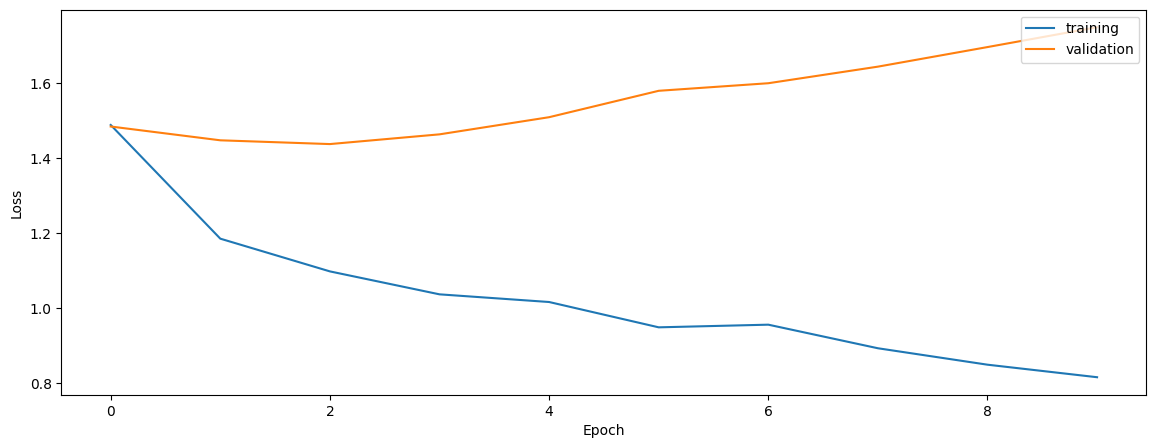

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5933413850819996
0.4634508592440653
0.500518077601411


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5684958448753462
0.4827030170590723
0.5604827293318233


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5753602950428105
0.50245174752217
0.581041463074131


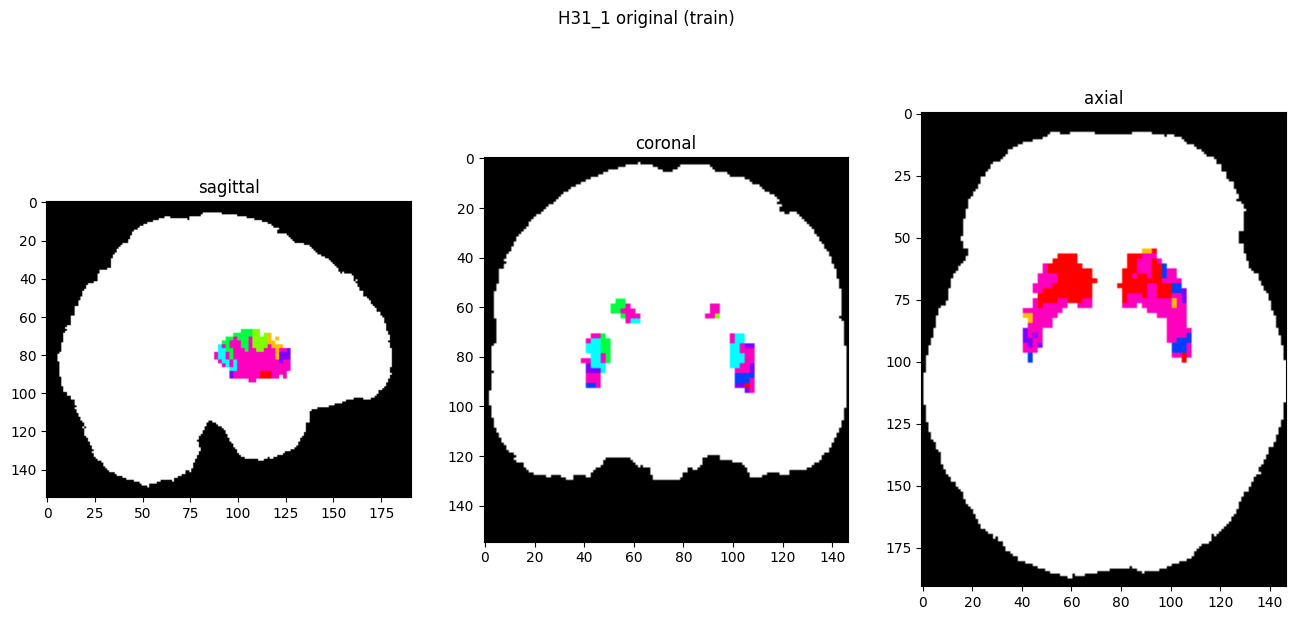

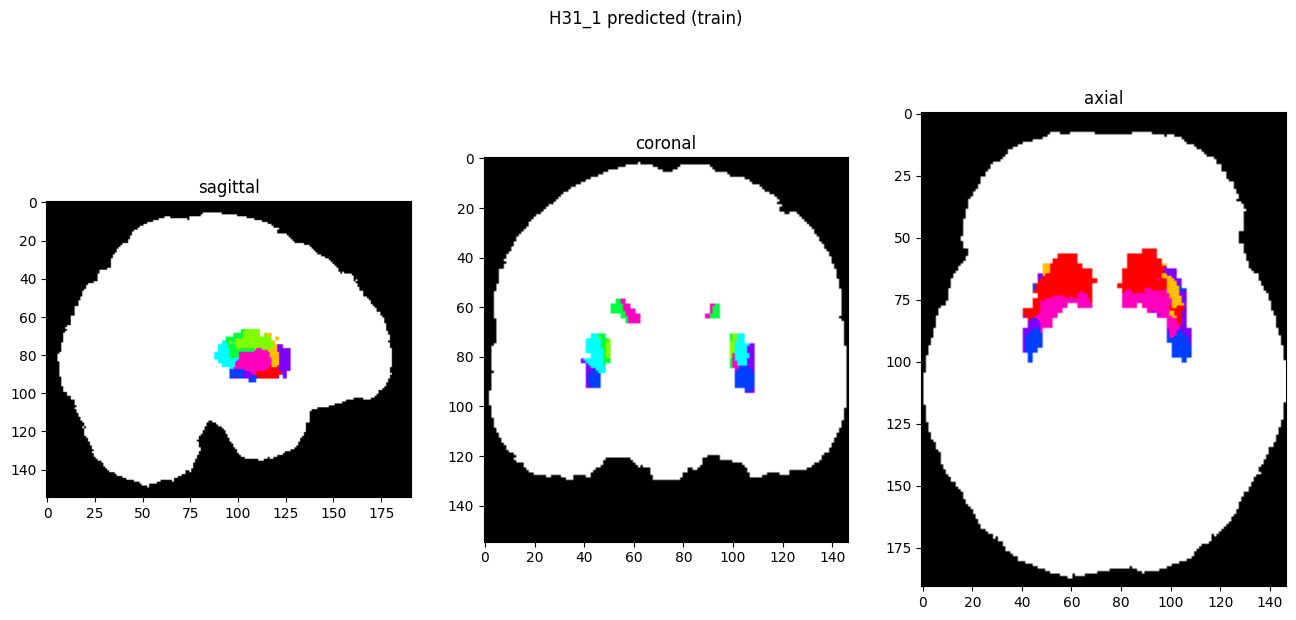

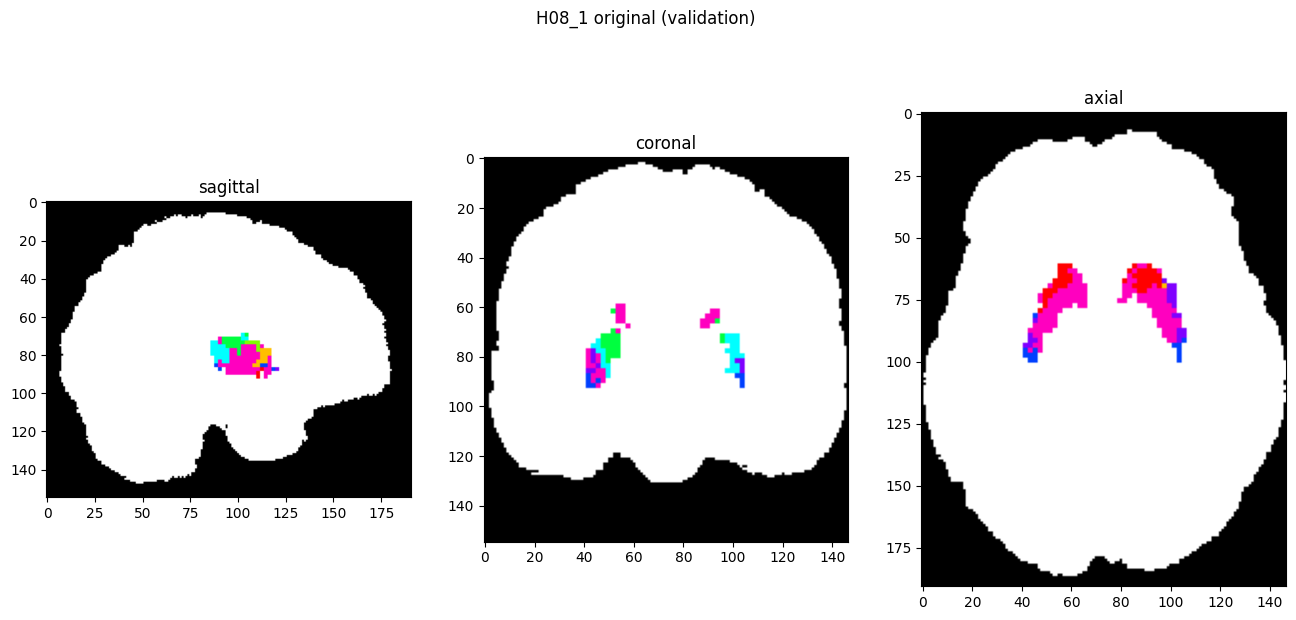

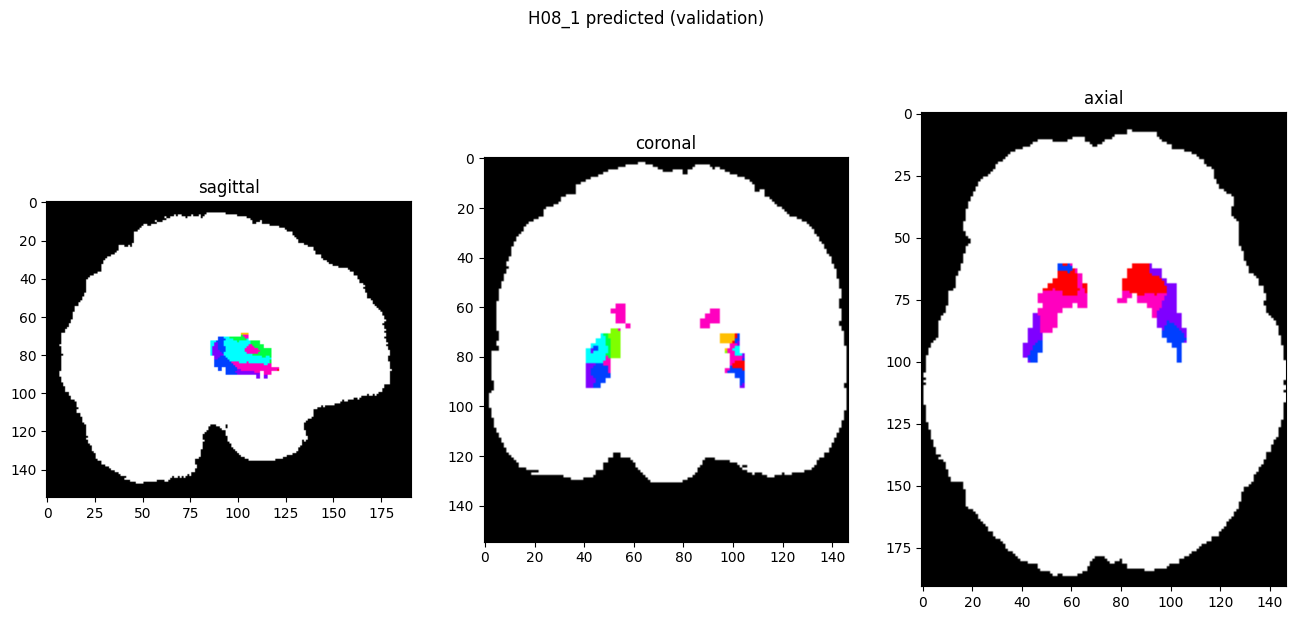

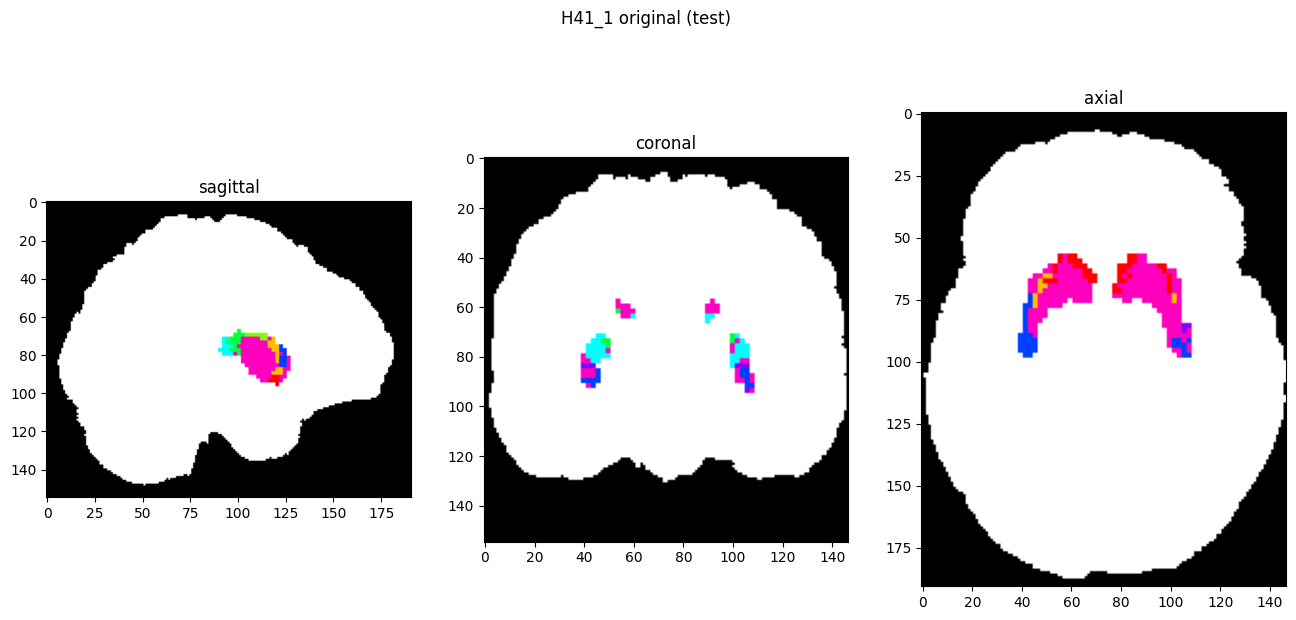

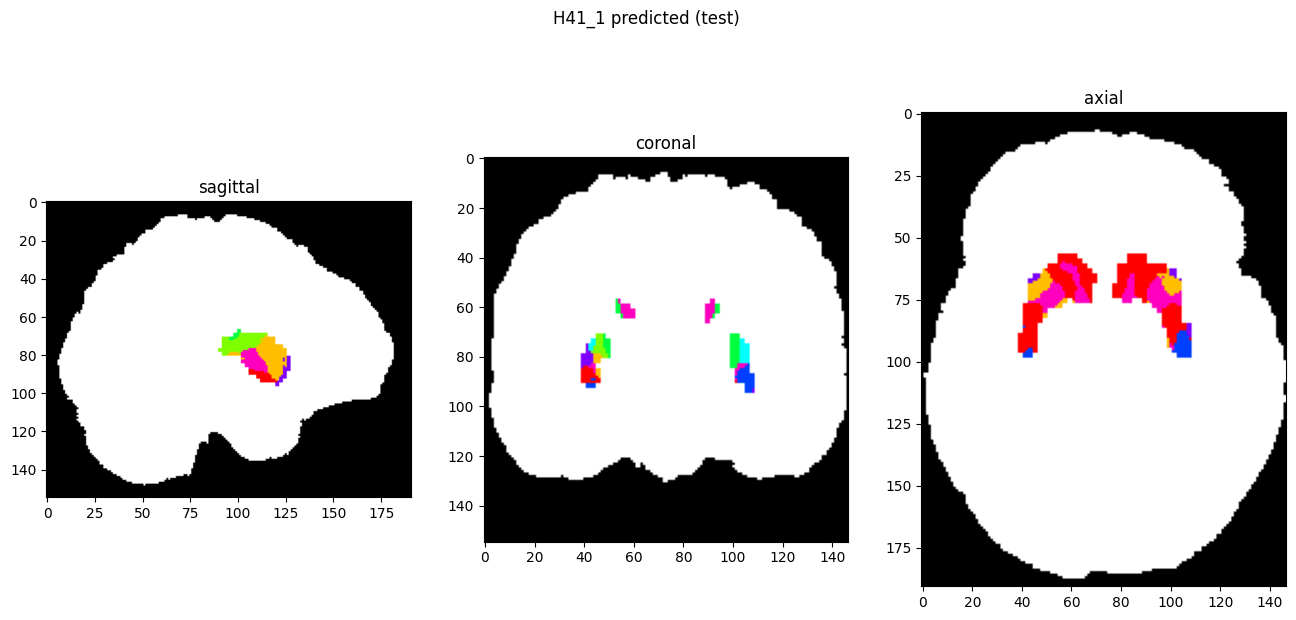

In [10]:
showResults(model, gen, threshold=0)